In [187]:
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input

from tqdm.notebook import trange

import numpy as np

import matplotlib.pyplot as plt
import scipy.stats as ss

import time

from tqdm.notebook import tqdm

import scipy.stats as ss

from latentPosteriorEstimation.msgmm import MSGMM

from sklearn.mixture import GaussianMixture

from sklearn.model_selection import train_test_split
from easydict import EasyDict

# Synthetic

In [2]:

from scipy.stats import norm, uniform,dirichlet
from scipy.stats import multivariate_normal as mvn
import scipy.stats as stats

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from random import seed, randint, random
from sklearn import metrics
from matplotlib import pyplot as plt
from types import SimpleNamespace as SN
from sklearn.datasets import make_spd_matrix as spd

class mixture:

    def __init__(self, components, mixing_proportion):
        self.comps = components
        self.mixProp = mixing_proportion
        # self.sigmoid = activations.sigmoid()

    def pdf(self, x):
        return np.sum((p * comp.pdf(x) for (comp, p) in zip(self.comps, self.mixProp)), axis=1)

    def cdf(self, x):
        return np.sum((p * comp.cdf(x) for (comp, p) in zip(self.comps, self.mixProp)), axis=1)

    def rvs(self, size):
        sizes = np.cast['int32'](np.floor(size * self.mixProp))
        #pdb.set_trace()
        delta = np.cast['int32'](size - np.sum(sizes))
        ix = np.random.choice(np.size(self.mixProp), size=delta, p=self.mixProp)
        for ii in ix:
            sizes[ii] = sizes[ii] + 1
        dim = np.size(self.comps[0].rvs(size=1))
        x = np.empty([0, dim])
        for (s, comp) in zip(sizes, self.comps):
            new = comp.rvs(size=[s, 1])
            if len(new.shape) == 1:
                new = np.expand_dims(new,1)
            x = np.concatenate((x,new), axis=0)
        #pdb.set_trace()
        return x

    def rvsCompInfo(self, size):
        sizes = np.cast['int32'](np.floor(size * self.mixProp))
        #pdb.set_trace()
        delta = np.cast['int32'](size - np.sum(sizes))
        ix = np.random.choice(np.size(self.mixProp), size=delta, p=self.mixProp)
        for ii in ix:
            sizes[ii] = sizes[ii] + 1
        dim = np.size(self.comps[0].rvs(size=1))
        x = np.empty([0, dim])
        y = np.empty([0, 1])
        k = 0
        for (s, comp) in zip(sizes, self.comps):
            new = comp.rvs(size=[s, 1])
            print(x.shape, new.shape)
            x = np.concatenate((x, new), axis=0)
            y = np.concatenate((y, np.zeros([s, 1]) + k), axis=0)
            k = k + 1
        #pdb.set_trace()
        return x, y

    def component_pdfs(self, x):
        return (comp.pdf(x) for comp in self.comps)

class DataGenerator:

    def __init__(self, dist_p, dist_n, alpha, n_p, n_u, batch_size=1024):
        self.dist_p = dist_p
        self.dist_n = dist_n
        self.alpha = alpha
        self.n_p = n_p
        self.n_u = n_u
        self.n_up = np.cast['int32'](np.floor(n_u * alpha))
        self.n_un = self.n_u - self.n_up
        self.batch_size = batch_size

    @classmethod
    def _shuffle_in_unison(self, a, b):
        p = np.random.permutation(len(a))
        return a[p],b[p]
        
    def data_pos(self, n):
        #pdb.set_trace()
        return np.reshape(self.dist_p.rvs(size=n), newshape=(n, -1))


    def data_neg(self, n):
        return np.reshape(self.dist_n.rvs(size=n), newshape=(n, -1))

    def data_pos_compInfo(self, n):
        #pdb.set_trace()
        x, c = self.dist_p.rvsCompInfo(size=n)
        x = np.reshape(x, newshape=(n, -1))
        return x, c

    def data_neg_compInfo(self, n):
        x, c = self.dist_n.rvsCompInfo(size=n)
        x = np.reshape(x, newshape=(n, -1))
        return x, c

    def data_ul(self, n, alpha):
        n_up = np.cast['int32'](np.floor(n * alpha))
        n_un = n - n_up
        x_up = self.data_pos(n_up)
        x_un = self.data_neg(n_un)
        x = np.concatenate((x_up, x_un), axis=0)
        y = np.zeros([n, 1])
        y[np.arange(x_up.shape[0]), 0] = 1
        return x, y

    def pu_data(self):
        x_p = self.data_pos(self.n_p)
        x_u, y_u = self.data_ul(self.n_u, self.alpha)
        x_pu = np.concatenate((x_p, x_u), axis=0)
        y_pu = np.zeros([x_pu.shape[0], 1])
        y_pu[np.arange(self.n_p), 0] = 1
        y_pn = np.concatenate((np.ones([self.n_p, 1]), y_u), axis=0)
        # y_pn = y_pu
        # y_pn[x_pu.size(0):(self.n_p - 1):-1, 0] = y_u
        return x_pu, y_pu, y_pn
        
    def pn_data(self, n, alpha):
        "return x,y"
        x_p = self.data_pos(int(alpha*n))
        x_n = self.data_neg(int((1-alpha)*n))
        y_p = np.ones((len(x_p), 1))
        y_n = np.zeros((len(x_n), 1))
        x = np.vstack((x_p, x_n))
        y = np.vstack((y_p, y_n))
        x, y = self._shuffle_in_unison(x, y)
        return x, y

    def pn_data_compInfo(self, n, alpha):
        x_p, c_p = self.data_pos_compInfo(int(alpha*n))
        x_n, c_n = self.data_neg_compInfo(int((1-alpha)*n))
        y_p = np.ones((len(x_p), 1))
        y_n = np.zeros((len(x_n), 1))
        x = np.vstack((x_p, x_n))
        y = np.vstack((y_p, y_n))
        c = np.vstack((c_p, c_n))
        return x, y, c
    
    def dens_pos(self, x):
        return self.dist_p.pdf(x)

    def dens_neg(self, x):
        return self.dist_n.pdf(x)

    def dens_mix(self, x, a):
        return a * self.dens_pos(x) + (1 - a) * self.dens_neg(x)

    def pn_posterior(self, x, a):
        return a * self.dens_pos(x) / self.dens_mix(x, a)

    def pu_posterior(self, x):
        c1 = self.n_p / (self.n_u + self.n_p)
        c2 = (self.n_up + self.n_p) / (self.n_u + self.n_p)
        return c1 * self.dens_pos(x) / self.dens_mix(x, c2)

    def pn_posterior_sts(self, x):
        c = (self.n_up + self.n_p) / (self.n_u + self.n_p)
        return self.pn_posterior(x, c)

    def pn_posterior_cc(self, x):
        return self.pn_posterior(x, self.alpha)

    def pn_posterior_balanced(self, x):
        return self.pn_posterior(x, 0.5)


class GaussianDG(DataGenerator):

    def __init__(self, mu, sig, alpha, n_p, n_u, batch_size=1024):
        dist_p = norm(loc=0, scale=1)
        dist_n = norm(loc=mu, scale=sig)
        super(GaussianDG, self).__init__(dist_p=dist_p, dist_n=dist_n, alpha=alpha, n_p=n_p, n_u=n_u, batch_size=batch_size)


class UniformDG(DataGenerator):

    def __init__(self, mu, sig, alpha, n_p, n_u, batch_size=1024):
        dist_p = uniform(loc=0, scale=1)
        dist_n = uniform(loc=mu, scale=sig)
        super(UniformDG, self).__init__(dist_p=dist_p, dist_n=dist_n, alpha=alpha, n_p=n_p, n_u=n_u, batch_size=batch_size)


class NormalMixDG(DataGenerator):

    def __init__(self, mu_pos, sig_pos, p_pos, mu_neg, sig_neg, p_neg, alpha, n_pos, n_ul, batch_size = 1024):
        components_pos = [norm(loc=mu, scale=sig) for (mu, sig) in zip(mu_pos, sig_pos)]
        components_neg = [norm(loc=mu, scale=sig) for (mu, sig) in zip(mu_neg, sig_neg)]
        dist_pos = mixture(components_pos, p_pos)
        dist_neg = mixture(components_neg, p_neg)
        super(NormalMixDG, self).__init__(dist_p=dist_pos, dist_n=dist_neg, alpha=alpha, n_p=n_pos, n_u=n_ul, batch_size=batch_size)


class MVNormalMixDG(DataGenerator):

    def __init__(self, mu_pos, sig_pos, p_pos, mu_neg, sig_neg, p_neg, alpha, n_pos, n_ul, batch_size = 1024):
        self.components_pos = [mvn(mean=mu, cov=sig) for (mu, sig) in zip(mu_pos, sig_pos)]
        self.components_neg = [mvn(mean=mu, cov=sig) for (mu, sig) in zip(mu_neg, sig_neg)]
        dist_pos = mixture(self.components_pos, p_pos)
        dist_neg = mixture(self.components_neg, p_neg)
        super(MVNormalMixDG, self).__init__(dist_p=dist_pos, dist_n=dist_neg, alpha=alpha, n_p=n_pos, n_u=n_ul, batch_size=batch_size)


class NormalMixParameters:

    def __init__(self, dim, max_comps, quiet=False):
        self.dim = dim
        self.max_comps = max_comps
        #self.n_comps_pos = randint(1, max_comps)
        #self.n_comps_neg = randint(1, max_comps)
        self.n_comps_pos = max_comps
        self.n_comps_neg = max_comps
        self.mu_pos = list()
        self.mu_neg = list()
        for i in np.arange(max(self.n_comps_pos, self.n_comps_neg)):
            mu = np.array([16/np.sqrt(self.dim) * random() - 8/np.sqrt(self.dim) for i in np.arange(self.dim)])
            if i < self.n_comps_pos:
                self.mu_pos.append(mu)
            if i < self.n_comps_neg:
                self.mu_neg.append(mu)
        #self.mu_pos = [np.zeros(dim) for j in np.arange(self.n_comps_pos)]
        #self.mu_neg = [np.zeros(dim) for j in np.arange(self.n_comps_neg)]
        self.sig_pos = [np.identity(dim) for j in np.arange(self.n_comps_pos)]
        self.sig_neg = [np.identity(dim) for j in np.arange(self.n_comps_neg)]
        self.p_pos = dirichlet(np.ones(self.n_comps_pos)).rvs([])
        #self.p_neg = dirichlet(np.ones(self.n_comps_neg)).rvs([])
        self.p_neg = self.p_pos
        #self.changeInfo = {'changed': False, 'positive': True, 'mu': True, 'ix':0, 'oldvalue': self.mu_pos[0]}
        self.changeInfo = {'changed': False}
        self.alpha = random()
        self.quiet = quiet

    def computePNDataMetrics(self):
        epsilon = 0.05
        n = 10000
        _, x, y, pos, neg, dg = self.generatePNData(n, n)
        posterior_pos = dg.pn_posterior_balanced(pos)
        irreducibility = np.mean(np.cast['int32'](posterior_pos > 1-epsilon).flatten())
        posterior_x = dg.pn_posterior_balanced(x)
        fpr, tpr, thresholds = metrics.roc_curve(y, posterior_x)
        aucpn = metrics.auc(fpr, tpr)
        #pdb.set_trace()
        return {'aucpn': aucpn, 'irreducibility': irreducibility}

    def createDataGenerator(self, n_pos, n_ul):
        dg = MVNormalMixDG(self.mu_pos, self.sig_pos, self.p_pos, self.mu_neg, self.sig_neg, self.p_neg, self.alpha,
                         n_pos, n_ul)
        return dg

    def generatePNData(self, n_pos, n_neg):
        dg = self.createDataGenerator(50, 500)
        pos = dg.data_pos(n_pos)
        neg = dg.data_neg(n_neg)
        y = np.concatenate((np.ones([n_pos, 1]), np.zeros([n_neg, 1])), axis=0)
        x = np.concatenate((pos, neg), axis=0)
        xy = np.concatenate((x, y), axis=1)
        #pdb.set_trace()
        return xy, x, y, pos, neg, dg

    def perturb2SatisfyMetrics(self, irr_range, aucpn_range):
        irr_mid = np.mean(irr_range, axis=0)
        aucpn_min = min_aucpn(irr_mid)
        # if aucpn_range[0] < aucpn_min:
        #    raise ValueError('Irreducibility range and AUCPN range are not compatible:\n',
        #                      'AUCPN should be above', aucpn_min, 'for midpoint irreducibility of', irr_mid)
        while not self.isMetricSatisfied(irr_range, aucpn_range):
            self.markRandomParForChange()
            #print(self.changeInfo)
            if self.muMarked():
                self.perturbMu(irr_range, aucpn_range)
            else:
                if self.pMarked():
                    self.perturbProportion(irr_range, aucpn_range)
                else:
                    if random() <= 1:
                        self.perturbSigmaShape(irr_range, aucpn_range)
                    else:
                        self.perturbSigmaScale(irr_range, aucpn_range)
            self.commitChange()

    def perturbMu(self, irr_range, aucpn_range):
        if not self.quiet:
            print('Mu Perturb')
        c = 0.1
        delta = np.array([2 * random( ) - 1 for i in np.arange(self.dim)])
        delta = c * delta/np.linalg.norm(delta)
        mu = self.getMarkedParOldValue()
        up = 1.0
        self.proposeChange(mu + up * delta)
        while not self.isMetricUBSatisfied(irr_range, aucpn_range):
            up = up/2
            self.proposeChange(mu + up * delta)

    def perturbSigmaShape(self, irr_range, aucpn_range):
        if not self.quiet:
            print('Sigma Shape Perturb')
        newsigma = spd(self.dim)
        sigma = self.getMarkedParOldValue()
        a = 0.1
        self.proposeChange((1-a) * sigma + a * newsigma)
        while not self.isMetricUBSatisfied(irr_range, aucpn_range):
            a = a/2
            self.proposeChange((1-a) * sigma + a * newsigma)

    def perturbSigmaScale(self, irr_range, aucpn_range):
        if not self.quiet:
            print('Sigma Scale Perturb')
        sigma = self.getMarkedParOldValue()
        a = 1.5
        self.proposeChange(a * sigma)
        while not (self.isMetricUBSatisfied(irr_range, aucpn_range) and self.acceptableSigma(a * sigma)):
            a = 1 + (a - 1)/2
            #print(a)
            #print('metric:', self.isMetricUBSatisfied(irr_range, aucpn_range))
            #print('acceptable Sigma:', self.acceptableSigma(a * sigma) )
            self.proposeChange(a * sigma)

    def perturbProportion(self, irr_range, aucpn_range):
        if not self.quiet:
            print('Perturb Proportion')
        prop = self.getMarkedParOldValue( )
        a = 0.25
        if self.changeInfo['is_positive']:
            prop_1 = dirichlet(np.ones(self.n_comps_pos)).rvs([])
        else:
            prop_1 = dirichlet(np.ones(self.n_comps_neg)).rvs([])
        new_prop = (1 - a) * prop + a * prop_1
        self.proposeChange(new_prop)
        while not (self.isMetricUBSatisfied(irr_range, aucpn_range)):
            a = a/2
            new_prop = (1 - a) * prop + a * prop_1
            # print(a)
            self.proposeChange(new_prop)

    def muMarked(self):
        return self.changeInfo['is_mu']

    def pMarked(self):
        return self.changeInfo['is_proportion']

    def acceptableSigma(self, sigma):
        det = np.linalg.det(sigma)
        ratios = np.array([det/np.linalg.det(sig) for sig in self.sig_pos + self.sig_neg])
        if not self.quiet:
            print(ratios)
        ratios[:] = 1
        return all(ratios > 0.25)

    def isMetricSatisfied(self, irr_range, aucpn_range):
        metrics = self.computePNDataMetrics()
        irr_satisfied = irr_range[0] <= metrics['irreducibility'] <= irr_range[1]
        auc_satisfied = aucpn_range[0] <= metrics['aucpn'] <= aucpn_range[1]
        if not self.quiet:
            print(metrics)
        return irr_satisfied and auc_satisfied

    def isMetricUBSatisfied(self, irr_range, aucpn_range):
        metrics = self.computePNDataMetrics()
        irr_satisfied = metrics['irreducibility'] <= irr_range[1]
        auc_satisfied = metrics['aucpn'] <= aucpn_range[1]
        return irr_satisfied and auc_satisfied

    def proposeChange(self, newValue):
        self.changeInfo['changed'] = True
        V = SN(**self.changeInfo)
        self.updatePar(V.is_positive, V.is_mu, V.is_proportion, V.ix, newValue)

    def commitChange(self):
        self.changeInfo = {'changed': False}

    def updatePar(self, is_positive, is_mu, is_proportion, ix, newValue):
        if is_positive:
            if is_mu:
                self.mu_pos[ix] = newValue
            else:
                if is_proportion:
                    self.p_pos = newValue
                else:
                    self.sig_pos[ix] = newValue
        else:
            if is_mu:
                self.mu_neg[ix] = newValue
            else:
                if is_proportion:
                    self.p_neg = newValue
                else:
                    self.sig_neg[ix] = newValue

    def markRandomParForChange(self):
        if self.changeInfo['changed']:
            raise ValueError('Attempting to change a new parameter before committing the previous one')
        is_positive = random() < 0.5
        rr = random()
        is_mu = rr < 1.0/3.0
        is_proportion = 1.0/3.0 <= rr <= 2.0/3.0
        ix = np.nan
        if is_positive:
            ix = randint(0, self.n_comps_pos - 1)
            if is_mu:
                value = self.mu_pos[ix]
            else:
                if is_proportion:
                    value = self.p_pos
                else:
                    value = self.sig_pos[ix]
        else:
            ix = randint(0, self.n_comps_neg - 1)
            if is_mu:
                value = self.mu_neg[ix]
            else:
                if is_proportion:
                    value = self.p_neg
                else:
                    value = self.sig_neg[ix]

        self.changeInfo.update({'is_positive': is_positive, 'is_mu': is_mu, 'is_proportion': is_proportion, 'ix': ix, 'oldValue': value})

    def getMarkedParOldValue(self):
        return self.changeInfo['oldValue']

    def revert2OldValue(self):
        V = SN(**self.changeInfo)
        self.updatePar(V.is_positive, V.is_mu, V.ix, V.oldValue)
        self.changeInfo['changed'] = False
        return

def min_aucpn(irreducibility):
    return irreducibility + (1-irreducibility)/2

def GaussianMixtureDataGenerator(dim, n_comps, aucpn_range, n_p, n_u, irreducibility_range=[0.1,1]):
    NMix = NormalMixParameters(dim, n_comps,quiet=True)
    NMix.perturb2SatisfyMetrics(irreducibility_range, aucpn_range)
    dg = NMix.createDataGenerator(n_p, n_u)
    return dg



In [34]:
dim = 1
n_comps = 1
aucpn_range = [0.9, 0.99]
n_p = 5000
n_u = 20000
dg = GaussianMixtureDataGenerator(dim, n_comps, aucpn_range, n_p, n_u,irreducibility_range=[.01,1])
x, yPU, yPN = dg.pu_data()
yPU = yPU.astype(bool).ravel()
yPN = yPN.astype(bool).ravel()
xTrain, xVal, yPUTrain, yPUVal, yPNTrain, yPNVal = train_test_split(x,yPU,yPN, test_size=.1)
xUnlabeledTrain = xTrain[~yPUTrain]
xPosTrain = xTrain[yPUTrain]
xUnlabeledVal = xVal[~yPUVal]
xPosVal = xVal[yPUVal]
posterior = lambda x: dg.pn_posterior(x, dg.alpha)

/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


KeyboardInterrupt: 

In [35]:
# plt.hist(x[~yPU],label="unlabeled")
# plt.hist(x[yPU],label="positive")
# plt.legend()

In [177]:
NLP=1000
NUP = 5000
NN = 5000
classPrior = NUP / (NUP + NN)
# f0 = mixture([ss.beta(a=2,b=5),
#               ss.beta(a=2,b=3)],
#             [.5,.5])
# f1 = mixture([ss.beta(a=5,b=2),
#               ss.beta(a=3,b=2)],
#             [.5,.5])
# f0,f1 = ss.beta(a=2,b=5), ss.beta(a=5,b=2)
f0, f1 = ss.norm(loc=-2),ss.norm(loc=2)
posterior = lambda x: classPrior * f1.pdf(x) / (classPrior * f1.pdf(x) + (1 - classPrior) * f0.pdf(x))
xUnlabeled = np.concatenate((f0.rvs(NN),f1.rvs(NUP)))[:,None]
yPN = np.concatenate((np.zeros(NN),
                    np.ones(NUP))).astype(bool)
xPos = f1.rvs(NLP)[:,None]


xPosTrain, xPosVal = train_test_split(xPos,test_size=.1)
xUnlabeledTrain,xUnlabeledVal,yPNTrain,yPNVal = train_test_split(xUnlabeled,yPN,test_size=.1)

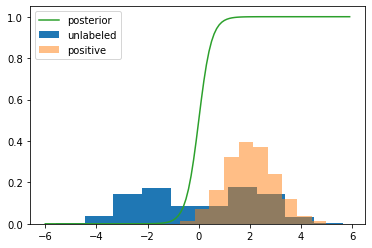

In [178]:
plt.hist(xUnlabeledTrain.ravel(),density=True,label="unlabeled")
plt.hist(xPosTrain.ravel(),density=True,alpha=.5,label="positive")
rng = np.arange(-6,6,.1)
plt.plot(rng, posterior(rng),label="posterior")
plt.legend()

In [202]:
class AdversarialAutoencoder:
    def __init__(self, input_shape, h_dim, z_dim, ae_loss_weight, gen_loss_weight, dc_loss_weight):
        self.input_shape = input_shape
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.ae_loss_weight = ae_loss_weight
        self.gen_loss_weight = gen_loss_weight
        self.dc_loss_weight = dc_loss_weight
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.mse = tf.keras.losses.MeanSquaredError()
        self.accuracy = tf.keras.metrics.BinaryAccuracy()
        self.makeModel()
        

    def makeEncoder(self,):
        inputs = tf.keras.Input(shape=(self.input_shape,))
        x = tf.keras.layers.Dense(self.h_dim)(inputs)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(self.h_dim)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        encoded = tf.keras.layers.Dense(self.z_dim)(x)
        self.encoder = tf.keras.Model(inputs=inputs, outputs=encoded)

    def makeDecoder(self):
        encoded = tf.keras.Input(shape=(self.z_dim,))
        x = tf.keras.layers.Dense(self.h_dim)(encoded)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(self.h_dim)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        reconstruction = tf.keras.layers.Dense(self.input_shape, activation=None)(x)
        self.decoder = tf.keras.Model(inputs=encoded, outputs=reconstruction)
        
    def makeDiscriminator(self):
        encoded = tf.keras.Input(shape=(self.z_dim,))
        x = tf.keras.layers.Dense(self.h_dim)(encoded)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(self.h_dim)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        prediction = tf.keras.layers.Dense(1,activation=None)(x)
        self.discriminator = tf.keras.Model(inputs=encoded, outputs=prediction)
        
    def makeModel(self):
        self.makeEncoder()
        self.makeDecoder()
        self.makeDiscriminator()
    
    def autoencoder_loss(self, inputs, reconstruction):
        mse = tf.keras.losses.MeanSquaredError()
        return self.ae_loss_weight * mse(inputs, reconstruction)

    
    def discriminator_loss(self, real_output, fake_output):
        loss_real = self.cross_entropy(tf.ones_like(real_output), real_output)
        loss_fake = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        return self.dc_loss_weight * (loss_fake + loss_real)


    def generator_loss(self, fake_output):
        return self.gen_loss_weight * self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def makeOptimizers(self, base_lr):
        self.ae_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
        self.dc_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
        self.gen_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
        
    def aeTrainStep(self,batch_x):
        # Autoencoder
        with tf.GradientTape() as ae_tape:
            encoder_output = self.encoder(batch_x, training=True)
            decoder_output = self.decoder(encoder_output, training=True)

            # Autoencoder loss
            ae_loss = self.autoencoder_loss(batch_x, decoder_output)
        ae_grads = ae_tape.gradient(ae_loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        self.ae_optimizer.apply_gradients(zip(ae_grads, self.encoder.trainable_variables + self.decoder.trainable_variables))
        self.epoch_ae_loss_avg(ae_loss)
        self.epochCounter += 1

    def discriminatorTrainStep(self, batch_x):
        # Discriminator
        with tf.GradientTape() as dc_tape:
#             real_distribution = tf.reshape(tf.map_fn(lambda x: tf.random.normal([int(batch_x.shape[0] / len(self.m)),],
#                                                                                mean=x[0],
#                                                                                stddev=x[1]),
#                                                     tf.cast(tf.concat([tf.reshape(self.m,(-1,1)),
#                                                                tf.reshape(tf.sqrt(self.s), (-1,1))],
#                                                               axis=1),tf.float32), dtype=tf.float32),
#                                           (-1,self.z_dim))
            mixingProportions = [1-  self.alpha,self.alpha]
            real_distribution = np.concatenate([
                np.random.multivariate_normal(self.m[i],
                                              self.s[i],
                                              size=int(batch_x.shape[0] * mixingProportions[i]))
            for i in range(self.m.shape[0])])
            
            encoder_output = self.encoder(batch_x, training=True)

            dc_real = self.discriminator(real_distribution, training=True)
            dc_fake = self.discriminator(encoder_output, training=True)

            # Discriminator Loss
            dc_loss = self.discriminator_loss(dc_real, dc_fake)
            # Discriminator Acc
            dc_acc = self.accuracy(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                              tf.concat([dc_real, dc_fake], axis=0) > .5)

        dc_grads = dc_tape.gradient(dc_loss, self.discriminator.trainable_variables)
        self.dc_optimizer.apply_gradients(zip(dc_grads, self.discriminator.trainable_variables))
        # Log Loss and Accuracy
        self.epoch_dc_loss_avg(dc_loss)
        self.epoch_dc_acc_avg(dc_acc)

    def generatorTrainStep(self, batch_x):
        # Generator (Encoder)
        with tf.GradientTape() as gen_tape:
            encoder_output = self.encoder(batch_x, training=True)
            dc_fake = self.discriminator(encoder_output, training=True)

            # Generator loss
            gen_loss = self.generator_loss(dc_fake)
            
        gen_grads = gen_tape.gradient(gen_loss, self.encoder.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.encoder.trainable_variables))
        # Log Loss
        self.epoch_gen_loss_avg(gen_loss)

    def train_step(self, batch_x):
        self.aeTrainStep(batch_x)
        self.discriminatorTrainStep(batch_x)
        self.generatorTrainStep(batch_x)
     
    def updateMeans(self):
        embeddingsU = self.encoder(self.xUnlabeled, training=False).numpy()
        embeddingsP = self.encoder(self.xPos,training=False).numpy()
        self.em = MSGMM()
        self.em.fit(embeddingsU, embeddingsP,verbose=False,iterations=100)
        self.m = np.stack((self.em.u0,
                                 self.em.u1))
        self.s = np.stack((self.em.sigma0,
                                 self.em.sigma1))
        self.alpha = self.em.alpha

    def fixParams(self,params):
        self.em = MSGMM()
        self.em.u1 = params.u1
        self.em.u0 = params.u0
        self.em.sigma1 = params.sigma1
        self.em.sigma0 = params.sigma0
        self.em.alpha = params.alpha
        self.alpha = params.alpha
        self.m = np.stack([
            self.em.u0,
            self.em.u1
        ])
        self.s = np.stack([
            self.em.sigma0,
            self.em.sigma1
        ])
    def plot(self,):
        X = np.concatenate((self.xUnlabeledVal,self.xPosVal))
        embeddings = self.encoder(X,training=False).numpy()
        if self.z_dim == 1:
            plt.hist(embeddings,density=True)
            r = np.arange(embeddings.min(), embeddings.max(),.01)
            f = mixture([ss.norm(self.m[0],self.s[0]),
                          ss.norm(self.m[1],self.s[1])],
                        [1-self.alpha,self.alpha])
            print(self.m, self.s)
            plt.plot(r,f.pdf(r).ravel())
            plt.show()
        resp = self.em.predict_proba(embeddings)
        
#         predPost = resp[:,1] * .5 / (resp[:,1] * .5 + resp[:,0] * .5)
        predPost = resp * self.em.alpha / (resp * self.em.alpha + (1-resp) * (1-self.em.alpha))
        plt.scatter(predPost,posterior(X))
        plt.show()

    def fit(self,xUnlabeled, xPos,validation_data=(np.array([]),np.array([])), n_epochs=50, batch_size=32,params=None):
        if params is not None:
            self.fixParams(params)
        else:
            # Initialize EM Algorithm
            self.m = np.zeros((2,self.z_dim))
            self.s = np.ones((2,self.z_dim,self.z_dim))
            self.alpha = .5
        # Make Dataset
        # Create the dataset iterator
        self.xUnlabeled = xUnlabeled
        self.xPos = xPos
        train_buf = 60000
        train_dataset = tf.data.Dataset.from_tensor_slices(np.concatenate((xUnlabeled,
                                                                           xPos)))
        train_dataset = train_dataset.shuffle(buffer_size=train_buf)
        train_dataset = train_dataset.batch(batch_size)
        (self.xUnlabeledVal, self.xPosVal) = validation_data
        # Define records
        self.ae_losses = []
        self.dc_losses = []
        self.dc_accs = []
        self.gen_losses = []
        
        # Define cyclic learning rate
        base_lr = 0.00025
        max_lr = 0.0025
        batch_size=32
        n_samples = 60000
        step_size = 2 * np.ceil(len(train_dataset) / batch_size)
        global_step = 0
        self.makeOptimizers(base_lr)
        # Start Training
        for epoch in trange(n_epochs):
            start = time.time()
            self.epochCounter = 0
            self.epoch_ae_loss_avg = tf.metrics.Mean()
            self.epoch_dc_loss_avg = tf.metrics.Mean()
            self.epoch_dc_acc_avg = tf.metrics.Mean()
            self.epoch_gen_loss_avg = tf.metrics.Mean()

            # Learning 
            for batch, (batch_x) in tqdm(enumerate(train_dataset),leave=False,total=len(train_dataset)):
                # -------------------------------------------------------------------------------------------------------------
                # Calculate cyclic learning rate
                global_step = global_step + 1
                cycle = np.floor(1 + global_step / (2 * step_size))
                x_lr = np.abs(global_step / step_size - 2 * cycle + 1)
                clr = base_lr + (max_lr - base_lr) * max(0, 1 - x_lr)
                self.ae_optimizer.lr = clr
                self.dc_optimizer.lr = clr
                self.gen_optimizer.lr = clr

                self.train_step(batch_x)


            epoch_time = time.time() - start
            print(self.epoch_ae_loss_avg.count, self.epochCounter)
            print('{:4d}: TIME: {:.2f} ETA: {:.2f} AE_LOSS: {:.4f} DC_LOSS: {:.4f} DC_ACC: {:.4f} GEN_LOSS: {:.4f}' \
                  .format(epoch, epoch_time,
                          epoch_time * (n_epochs - epoch),
                          self.epoch_ae_loss_avg.result(),
                          self.epoch_dc_loss_avg.result(),
                          self.epoch_dc_acc_avg.result(),
                          self.epoch_gen_loss_avg.result()))
            if params is None:
                self.updateMeans()
            self.plot()

In [203]:
aae = AdversarialAutoencoder(xPos.shape[1], 128,1, 1,1,1)

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
   0: TIME: 4.66 ETA: 466.14 AE_LOSS: 2.6640 DC_LOSS: 1.4900 DC_ACC: 0.5047 GEN_LOSS: 0.7083
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


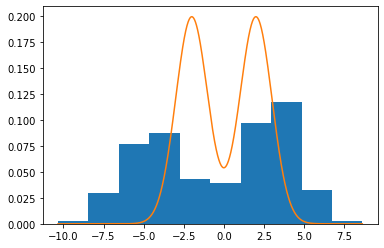

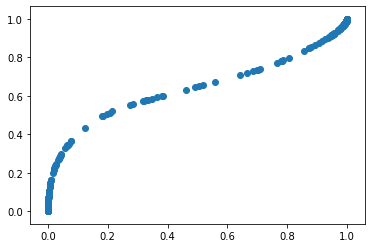

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
   1: TIME: 4.69 ETA: 464.39 AE_LOSS: 0.6082 DC_LOSS: 1.3907 DC_ACC: 0.5060 GEN_LOSS: 0.7287
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


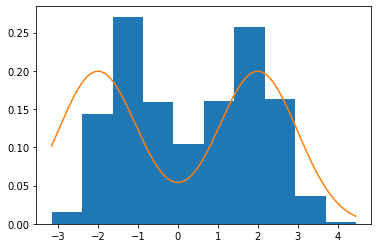

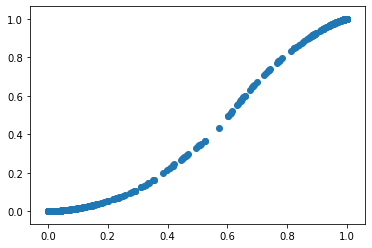

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
   2: TIME: 4.79 ETA: 469.88 AE_LOSS: 0.4577 DC_LOSS: 1.3956 DC_ACC: 0.5066 GEN_LOSS: 0.7276
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


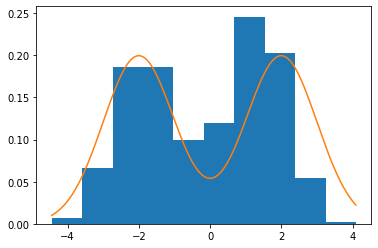

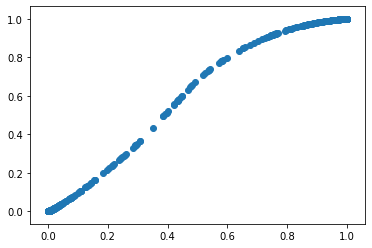

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
   3: TIME: 4.67 ETA: 452.95 AE_LOSS: 0.3703 DC_LOSS: 1.3921 DC_ACC: 0.5037 GEN_LOSS: 0.6803
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


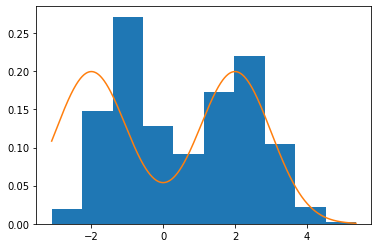

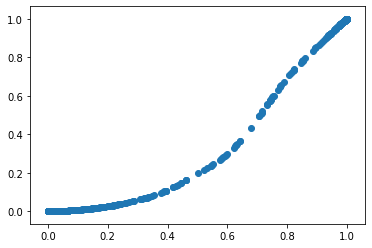

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
   4: TIME: 4.84 ETA: 464.30 AE_LOSS: 0.3379 DC_LOSS: 1.3935 DC_ACC: 0.5035 GEN_LOSS: 0.6879
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


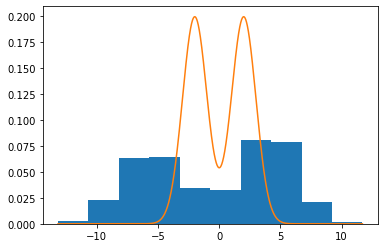

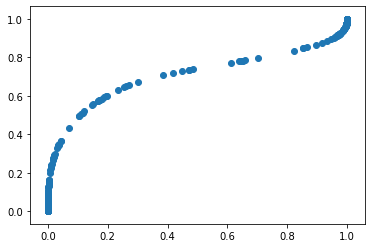

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
   5: TIME: 4.73 ETA: 449.60 AE_LOSS: 0.3601 DC_LOSS: 1.3856 DC_ACC: 0.5026 GEN_LOSS: 0.7021
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


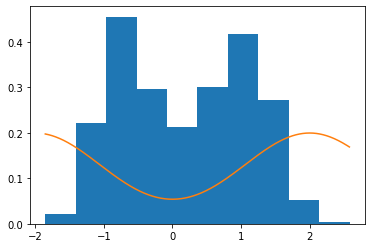

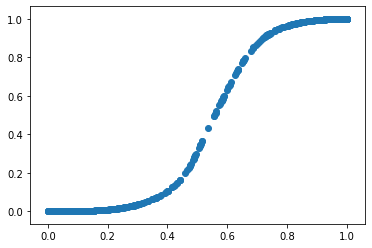

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
   6: TIME: 4.75 ETA: 446.78 AE_LOSS: 0.3460 DC_LOSS: 1.3751 DC_ACC: 0.5039 GEN_LOSS: 0.7078
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


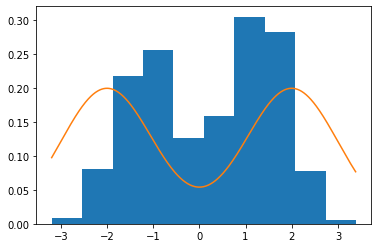

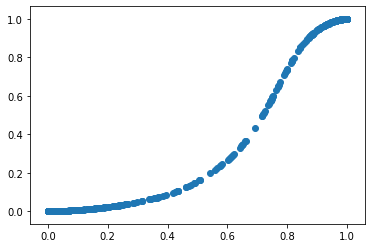

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
   7: TIME: 4.58 ETA: 425.56 AE_LOSS: 0.3265 DC_LOSS: 1.3827 DC_ACC: 0.5046 GEN_LOSS: 0.6919
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


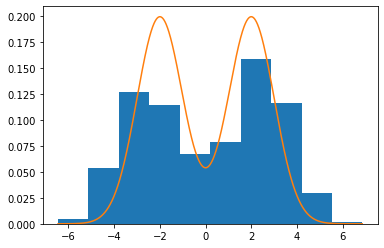

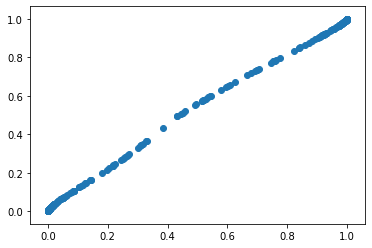

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
   8: TIME: 4.70 ETA: 432.18 AE_LOSS: 0.2779 DC_LOSS: 1.3892 DC_ACC: 0.5041 GEN_LOSS: 0.7162
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


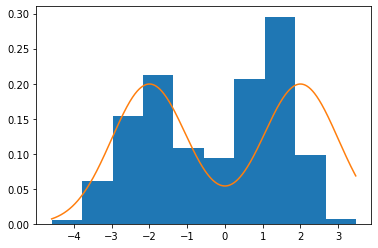

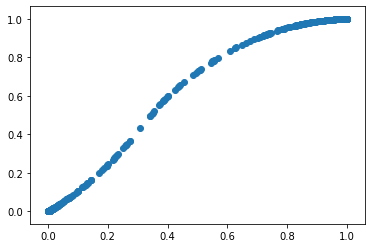

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
   9: TIME: 4.44 ETA: 404.21 AE_LOSS: 0.2324 DC_LOSS: 1.3888 DC_ACC: 0.5037 GEN_LOSS: 0.6928
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


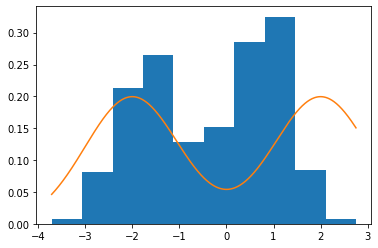

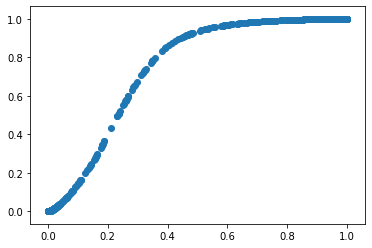

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  10: TIME: 4.54 ETA: 408.61 AE_LOSS: 0.2258 DC_LOSS: 1.3794 DC_ACC: 0.5034 GEN_LOSS: 0.6824
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


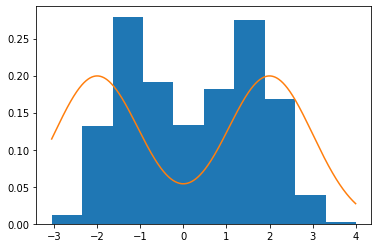

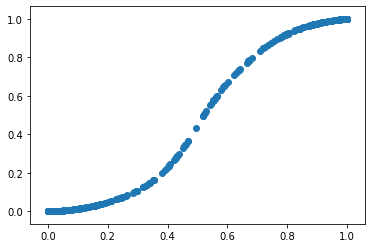

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  11: TIME: 4.60 ETA: 408.97 AE_LOSS: 0.2536 DC_LOSS: 1.3864 DC_ACC: 0.5033 GEN_LOSS: 0.7199
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


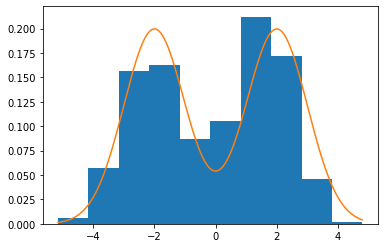

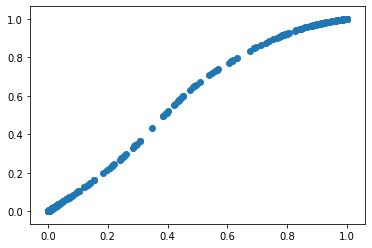

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  12: TIME: 4.67 ETA: 410.60 AE_LOSS: 0.2187 DC_LOSS: 1.3914 DC_ACC: 0.5027 GEN_LOSS: 0.6855
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


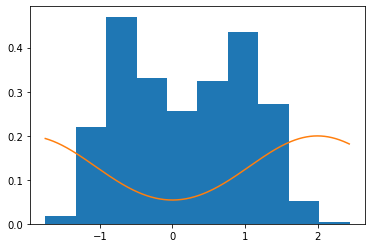

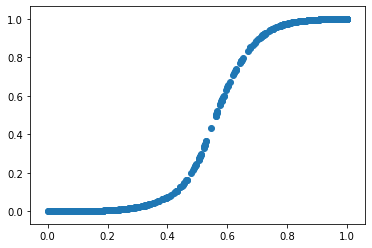

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  13: TIME: 4.72 ETA: 410.30 AE_LOSS: 0.1985 DC_LOSS: 1.3686 DC_ACC: 0.5025 GEN_LOSS: 0.6997
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


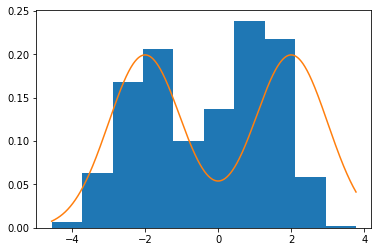

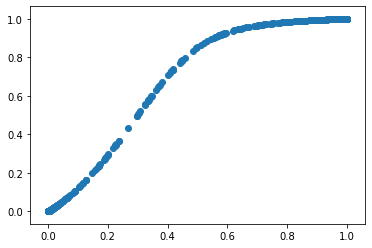

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  14: TIME: 4.68 ETA: 402.48 AE_LOSS: 0.3522 DC_LOSS: 1.4056 DC_ACC: 0.5023 GEN_LOSS: 0.7030
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


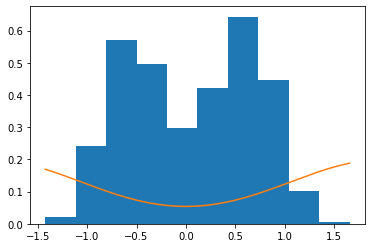

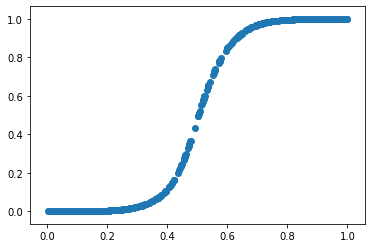

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  15: TIME: 4.72 ETA: 400.89 AE_LOSS: 0.2130 DC_LOSS: 1.3513 DC_ACC: 0.5022 GEN_LOSS: 0.6964
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


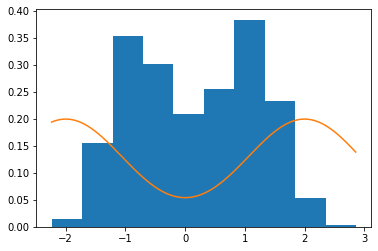

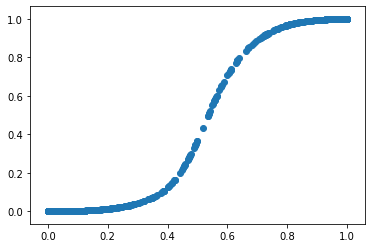

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  16: TIME: 4.73 ETA: 397.12 AE_LOSS: 0.4447 DC_LOSS: 1.4118 DC_ACC: 0.5032 GEN_LOSS: 0.7510
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


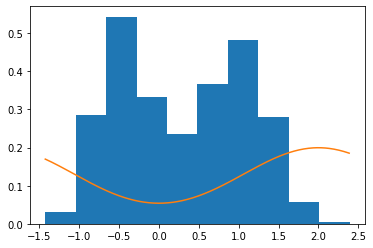

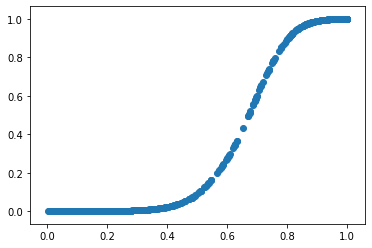

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  17: TIME: 4.60 ETA: 381.91 AE_LOSS: 0.3094 DC_LOSS: 1.3627 DC_ACC: 0.5029 GEN_LOSS: 0.6915
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


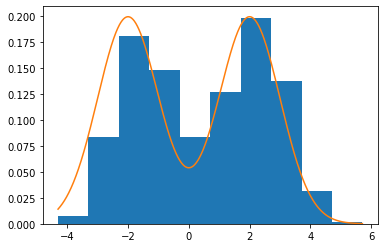

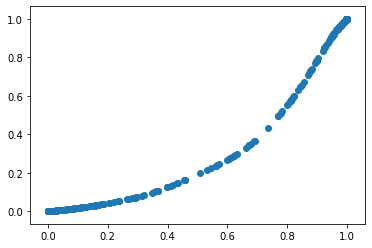

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  18: TIME: 4.73 ETA: 387.92 AE_LOSS: 0.2911 DC_LOSS: 1.4028 DC_ACC: 0.5033 GEN_LOSS: 0.7492
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


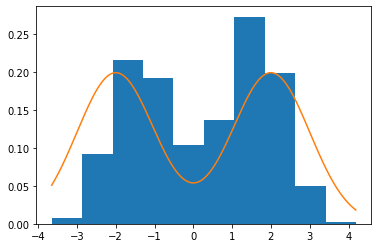

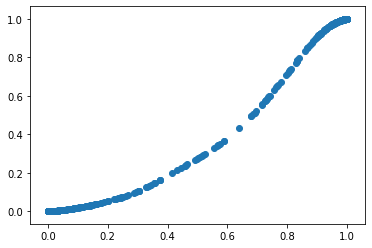

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  19: TIME: 4.54 ETA: 368.06 AE_LOSS: 0.2260 DC_LOSS: 1.3896 DC_ACC: 0.5036 GEN_LOSS: 0.6860
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


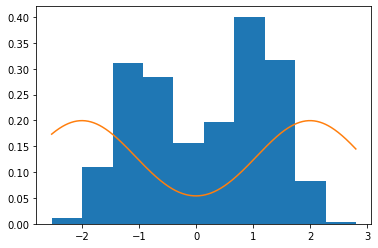

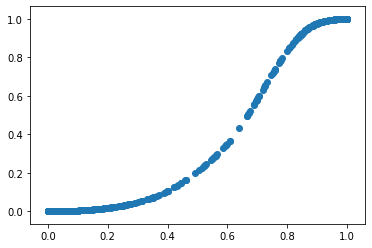

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  20: TIME: 4.52 ETA: 361.80 AE_LOSS: 0.1777 DC_LOSS: 1.3827 DC_ACC: 0.5034 GEN_LOSS: 0.6952
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


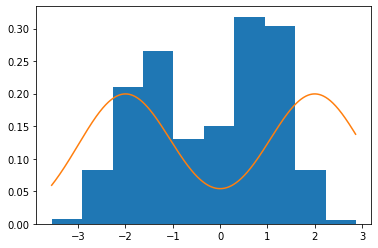

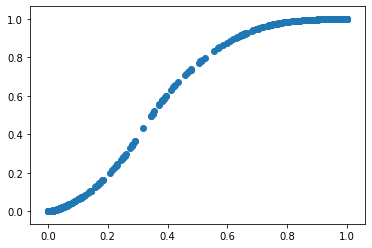

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  21: TIME: 4.53 ETA: 357.50 AE_LOSS: 0.1809 DC_LOSS: 1.3819 DC_ACC: 0.5033 GEN_LOSS: 0.7101
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


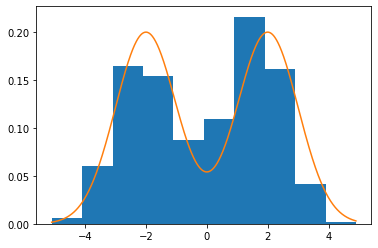

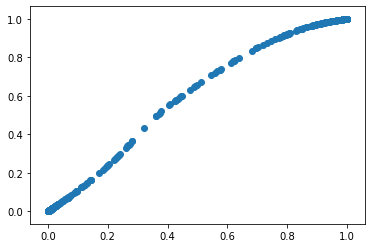

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  22: TIME: 4.69 ETA: 366.14 AE_LOSS: 0.1745 DC_LOSS: 1.3866 DC_ACC: 0.5033 GEN_LOSS: 0.6936
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


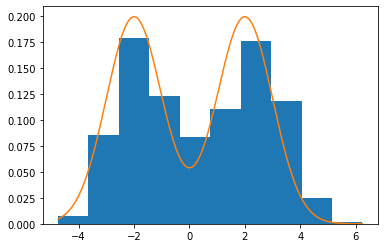

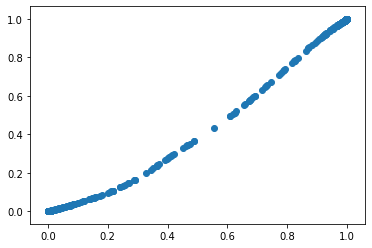

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  23: TIME: 4.55 ETA: 350.29 AE_LOSS: 0.1767 DC_LOSS: 1.3903 DC_ACC: 0.5031 GEN_LOSS: 0.7051
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


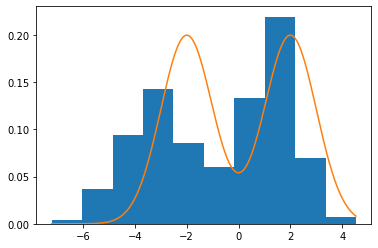

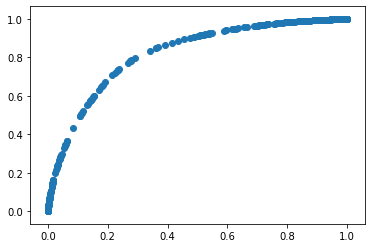

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  24: TIME: 4.60 ETA: 349.72 AE_LOSS: 0.1688 DC_LOSS: 1.3842 DC_ACC: 0.5030 GEN_LOSS: 0.7048
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


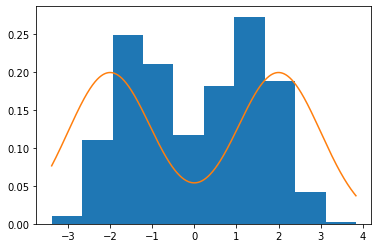

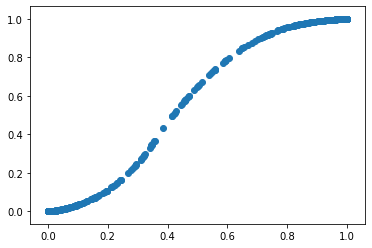

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  25: TIME: 4.74 ETA: 355.39 AE_LOSS: 0.1635 DC_LOSS: 1.3854 DC_ACC: 0.5029 GEN_LOSS: 0.6853
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


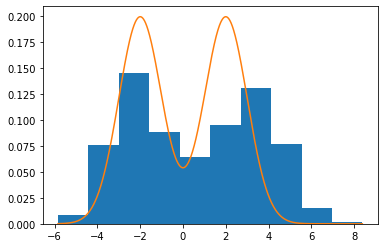

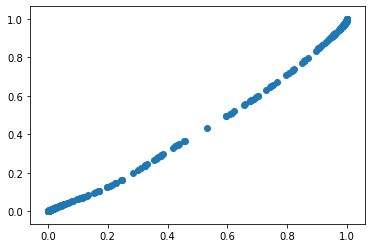

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  26: TIME: 4.50 ETA: 333.15 AE_LOSS: 0.1714 DC_LOSS: 1.3884 DC_ACC: 0.5028 GEN_LOSS: 0.7044
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


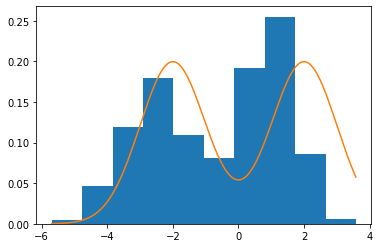

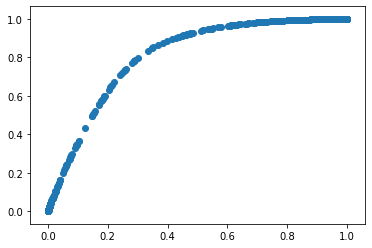

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  27: TIME: 4.56 ETA: 332.96 AE_LOSS: 0.1680 DC_LOSS: 1.3828 DC_ACC: 0.5027 GEN_LOSS: 0.7015
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


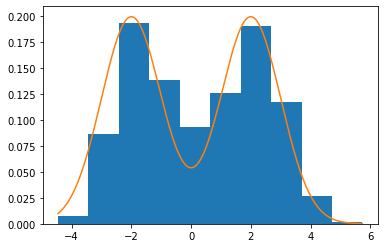

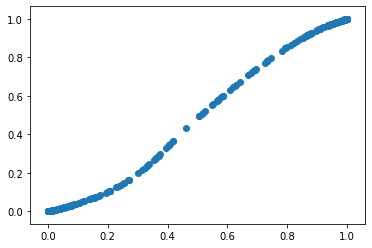

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  28: TIME: 4.62 ETA: 332.53 AE_LOSS: 0.1867 DC_LOSS: 1.3883 DC_ACC: 0.5026 GEN_LOSS: 0.6863
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


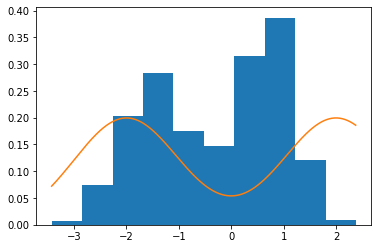

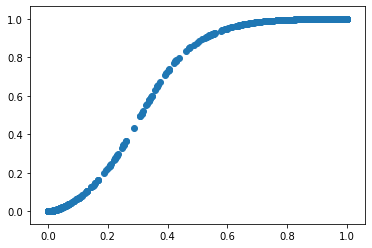

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  29: TIME: 4.50 ETA: 319.55 AE_LOSS: 0.1714 DC_LOSS: 1.3852 DC_ACC: 0.5025 GEN_LOSS: 0.7062
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


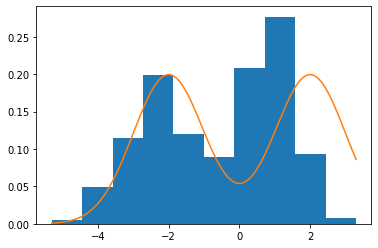

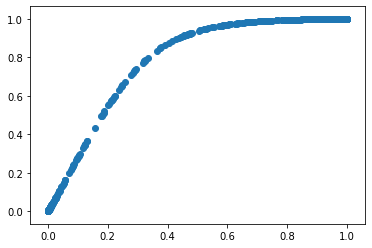

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  30: TIME: 4.58 ETA: 320.44 AE_LOSS: 0.1650 DC_LOSS: 1.3866 DC_ACC: 0.5025 GEN_LOSS: 0.6955
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


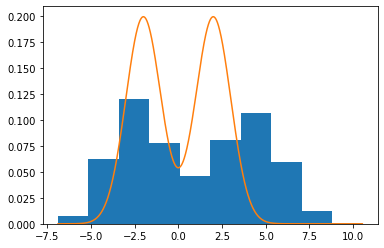

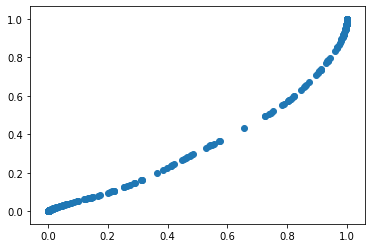

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  31: TIME: 4.58 ETA: 316.09 AE_LOSS: 0.1759 DC_LOSS: 1.3868 DC_ACC: 0.5024 GEN_LOSS: 0.6959
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


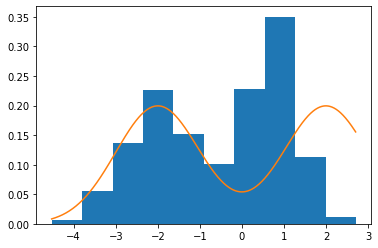

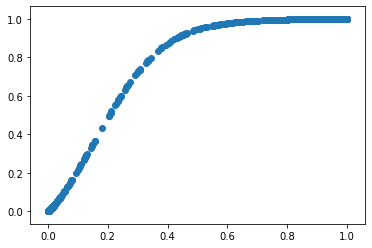

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  32: TIME: 4.55 ETA: 309.18 AE_LOSS: 0.1610 DC_LOSS: 1.3806 DC_ACC: 0.5023 GEN_LOSS: 0.7050
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


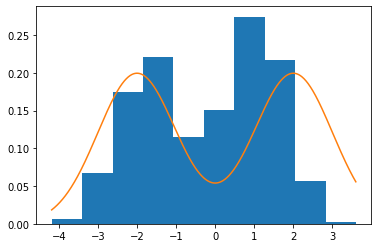

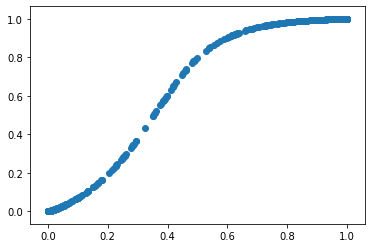

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  33: TIME: 4.52 ETA: 303.05 AE_LOSS: 0.1897 DC_LOSS: 1.3884 DC_ACC: 0.5024 GEN_LOSS: 0.7022
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


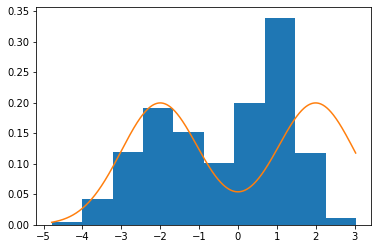

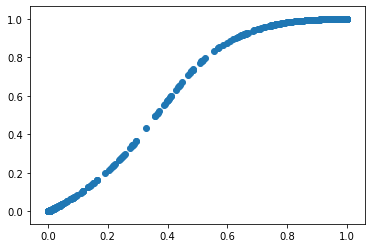

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  34: TIME: 4.52 ETA: 298.05 AE_LOSS: 0.1740 DC_LOSS: 1.3843 DC_ACC: 0.5023 GEN_LOSS: 0.7002
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


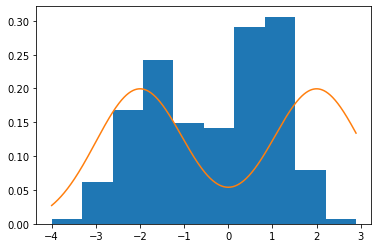

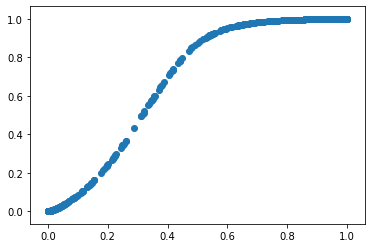

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  35: TIME: 4.47 ETA: 290.74 AE_LOSS: 0.1776 DC_LOSS: 1.3819 DC_ACC: 0.5025 GEN_LOSS: 0.7065
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


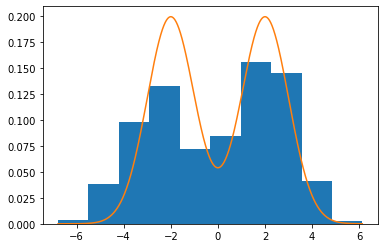

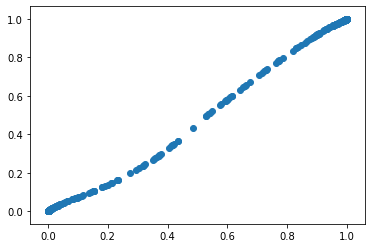

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  36: TIME: 4.53 ETA: 289.90 AE_LOSS: 0.1636 DC_LOSS: 1.3903 DC_ACC: 0.5025 GEN_LOSS: 0.6904
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


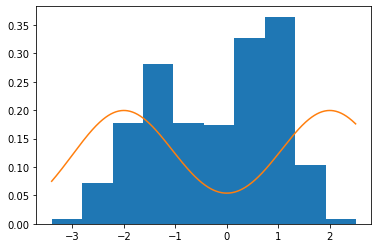

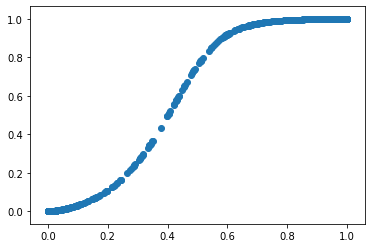

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  37: TIME: 4.40 ETA: 277.48 AE_LOSS: 0.1565 DC_LOSS: 1.3787 DC_ACC: 0.5025 GEN_LOSS: 0.7013
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


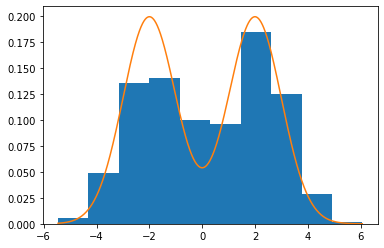

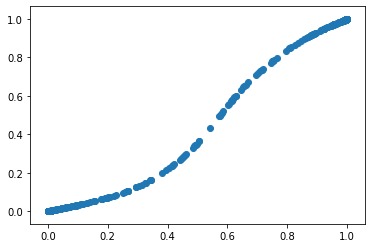

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  38: TIME: 4.42 ETA: 273.79 AE_LOSS: 0.2086 DC_LOSS: 1.3917 DC_ACC: 0.5024 GEN_LOSS: 0.6961
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


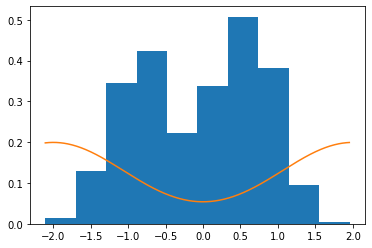

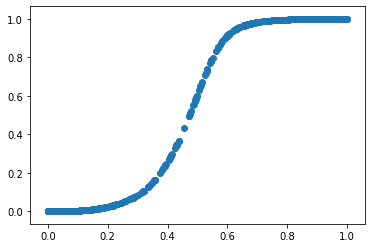

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  39: TIME: 4.49 ETA: 273.64 AE_LOSS: 0.1625 DC_LOSS: 1.3773 DC_ACC: 0.5023 GEN_LOSS: 0.7047
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


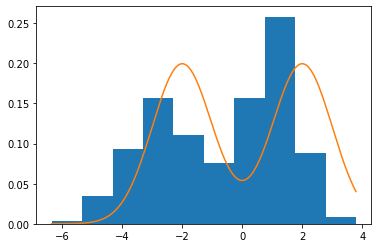

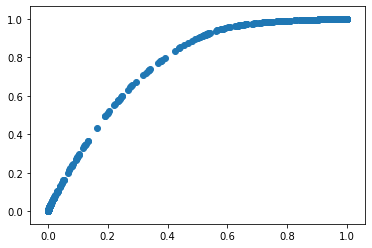

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  40: TIME: 4.46 ETA: 267.42 AE_LOSS: 0.1924 DC_LOSS: 1.3868 DC_ACC: 0.5025 GEN_LOSS: 0.7046
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


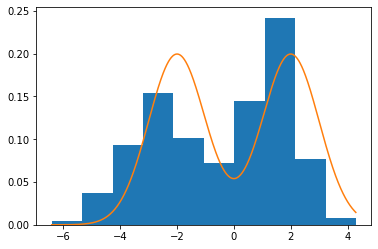

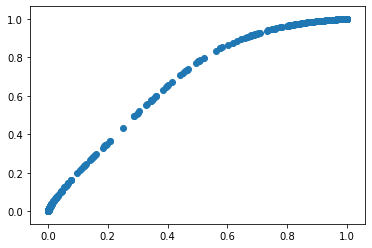

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  41: TIME: 4.40 ETA: 259.78 AE_LOSS: 0.1711 DC_LOSS: 1.3788 DC_ACC: 0.5024 GEN_LOSS: 0.7008
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


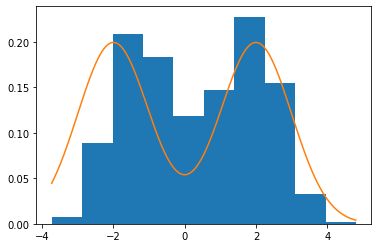

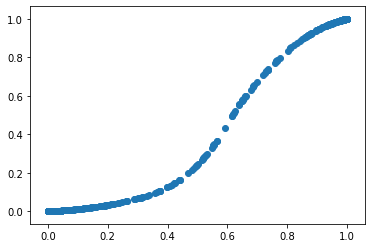

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  42: TIME: 4.40 ETA: 255.30 AE_LOSS: 0.2334 DC_LOSS: 1.3942 DC_ACC: 0.5025 GEN_LOSS: 0.6996
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


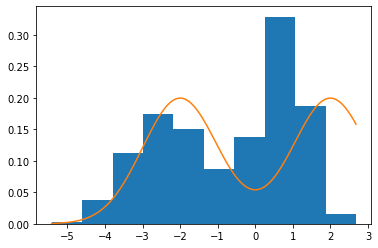

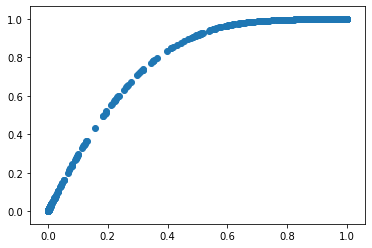

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  43: TIME: 4.48 ETA: 255.09 AE_LOSS: 0.1909 DC_LOSS: 1.3794 DC_ACC: 0.5025 GEN_LOSS: 0.6925
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


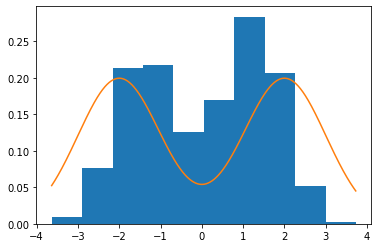

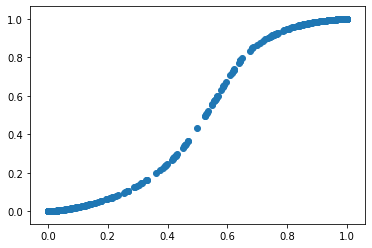

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  44: TIME: 4.49 ETA: 251.49 AE_LOSS: 0.1657 DC_LOSS: 1.3873 DC_ACC: 0.5026 GEN_LOSS: 0.7039
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


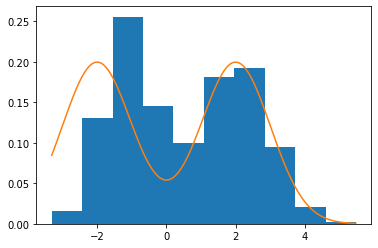

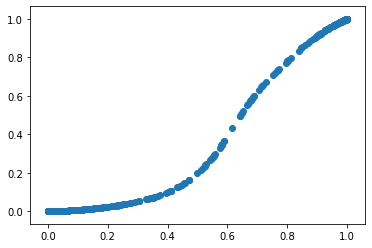

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  45: TIME: 4.48 ETA: 246.65 AE_LOSS: 0.1679 DC_LOSS: 1.3808 DC_ACC: 0.5025 GEN_LOSS: 0.7059
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


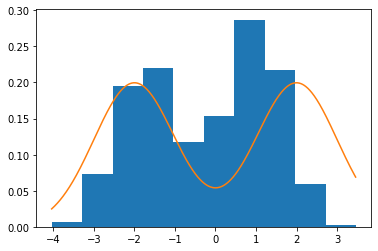

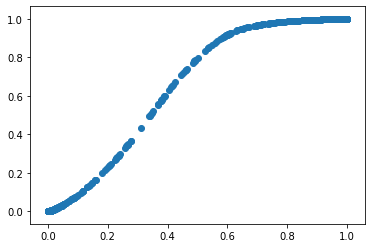

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  46: TIME: 4.56 ETA: 245.99 AE_LOSS: 0.1870 DC_LOSS: 1.3879 DC_ACC: 0.5025 GEN_LOSS: 0.6979
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


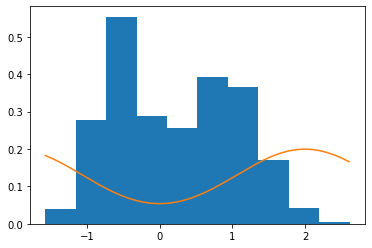

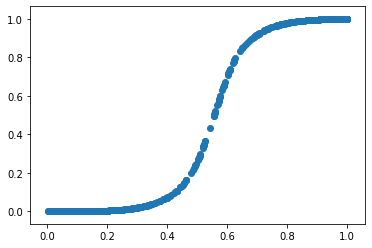

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  47: TIME: 4.47 ETA: 236.96 AE_LOSS: 0.1955 DC_LOSS: 1.3780 DC_ACC: 0.5027 GEN_LOSS: 0.7182
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


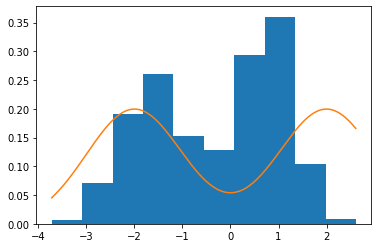

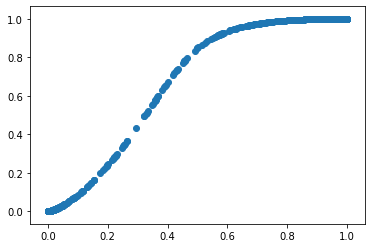

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  48: TIME: 4.47 ETA: 232.44 AE_LOSS: 0.1826 DC_LOSS: 1.3900 DC_ACC: 0.5028 GEN_LOSS: 0.6894
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


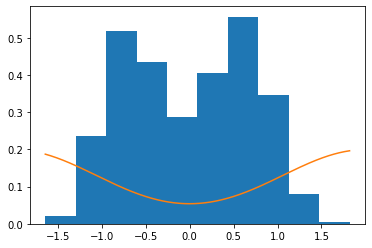

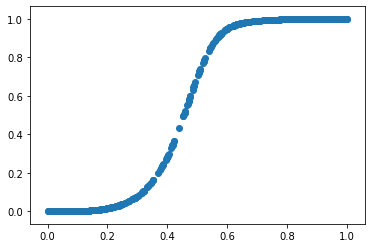

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  49: TIME: 4.39 ETA: 223.70 AE_LOSS: 0.1604 DC_LOSS: 1.3752 DC_ACC: 0.5027 GEN_LOSS: 0.7062
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


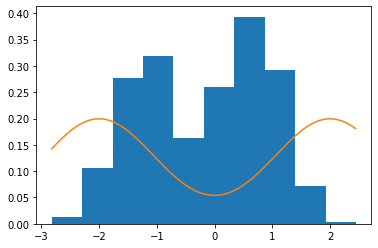

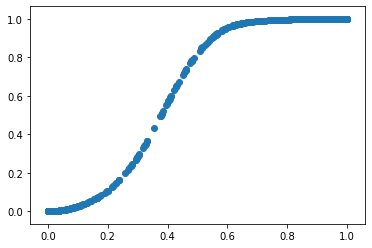

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  50: TIME: 4.60 ETA: 229.90 AE_LOSS: 0.2654 DC_LOSS: 1.3865 DC_ACC: 0.5027 GEN_LOSS: 0.7391
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


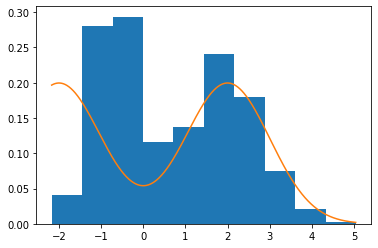

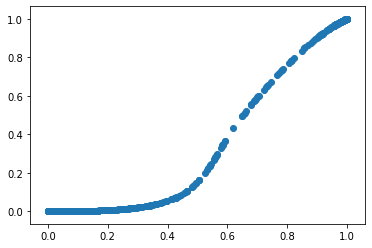

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  51: TIME: 4.49 ETA: 220.15 AE_LOSS: 0.2920 DC_LOSS: 1.3794 DC_ACC: 0.5034 GEN_LOSS: 0.7105
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


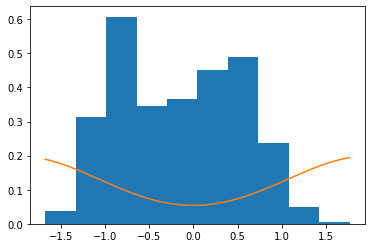

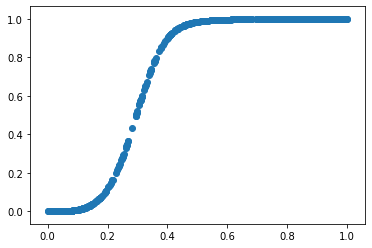

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  52: TIME: 4.48 ETA: 215.17 AE_LOSS: 0.2108 DC_LOSS: 1.3647 DC_ACC: 0.5041 GEN_LOSS: 0.7352
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


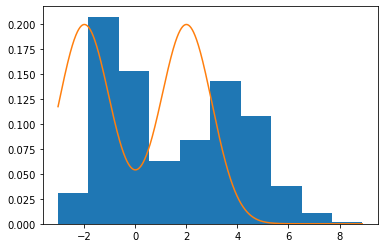

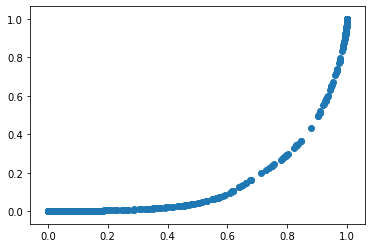

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  53: TIME: 4.59 ETA: 215.75 AE_LOSS: 0.3426 DC_LOSS: 1.3641 DC_ACC: 0.5053 GEN_LOSS: 0.7392
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


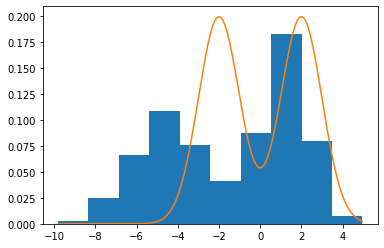

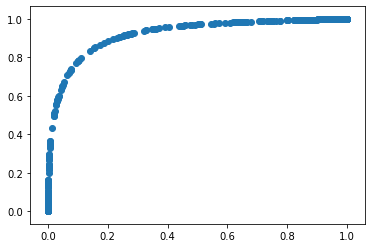

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  54: TIME: 4.64 ETA: 213.58 AE_LOSS: 0.3698 DC_LOSS: 1.3672 DC_ACC: 0.5062 GEN_LOSS: 0.7173
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


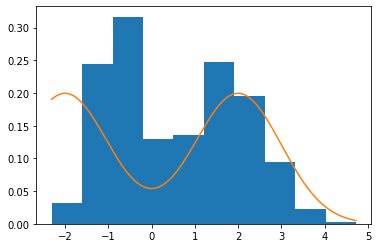

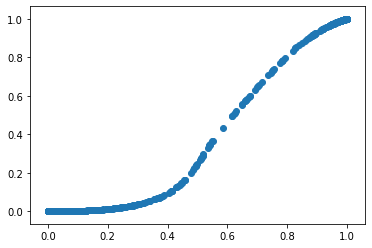

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  55: TIME: 4.42 ETA: 198.84 AE_LOSS: 0.2408 DC_LOSS: 1.3772 DC_ACC: 0.5070 GEN_LOSS: 0.7368
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


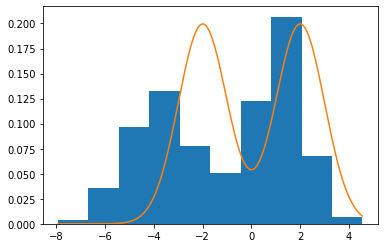

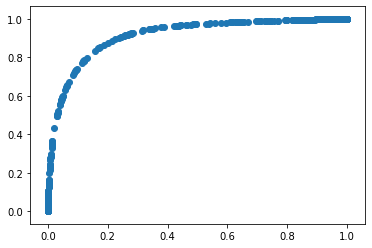

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  56: TIME: 4.47 ETA: 196.83 AE_LOSS: 0.2087 DC_LOSS: 1.3861 DC_ACC: 0.5073 GEN_LOSS: 0.7115
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


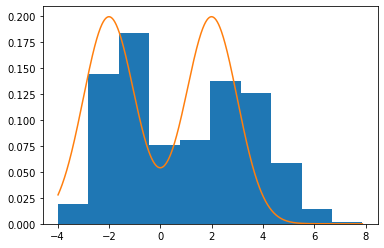

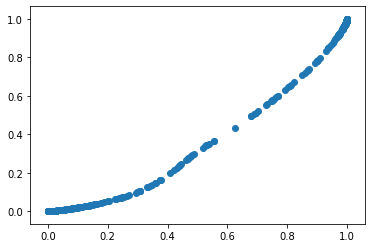

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  57: TIME: 4.49 ETA: 193.12 AE_LOSS: 0.1880 DC_LOSS: 1.3844 DC_ACC: 0.5073 GEN_LOSS: 0.7000
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


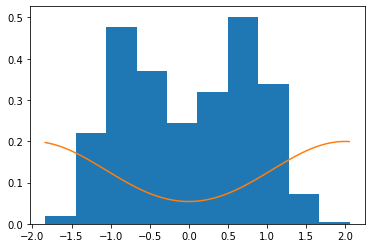

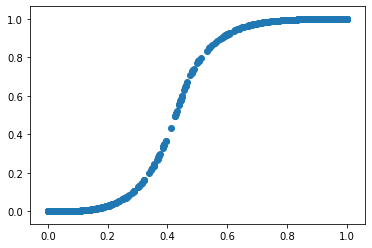

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  58: TIME: 4.37 ETA: 183.37 AE_LOSS: 0.1845 DC_LOSS: 1.3772 DC_ACC: 0.5076 GEN_LOSS: 0.7103
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


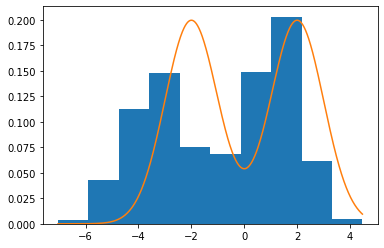

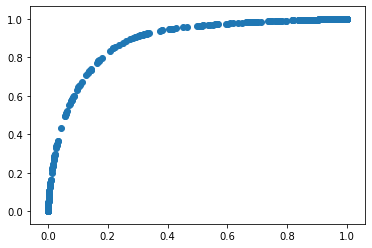

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  59: TIME: 4.53 ETA: 185.56 AE_LOSS: 0.1785 DC_LOSS: 1.3888 DC_ACC: 0.5076 GEN_LOSS: 0.6971
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


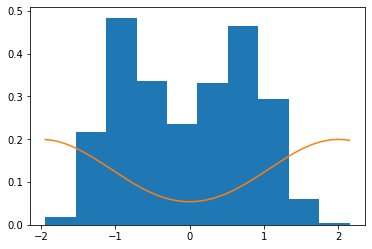

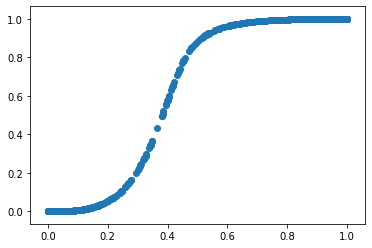

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  60: TIME: 4.55 ETA: 181.90 AE_LOSS: 0.1653 DC_LOSS: 1.3859 DC_ACC: 0.5075 GEN_LOSS: 0.6985
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


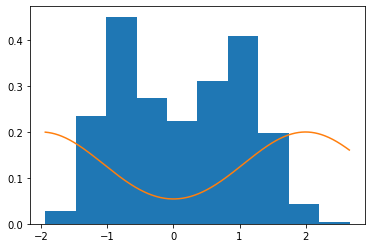

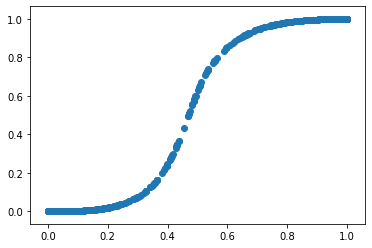

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  61: TIME: 4.51 ETA: 175.80 AE_LOSS: 0.1496 DC_LOSS: 1.3838 DC_ACC: 0.5074 GEN_LOSS: 0.7033
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


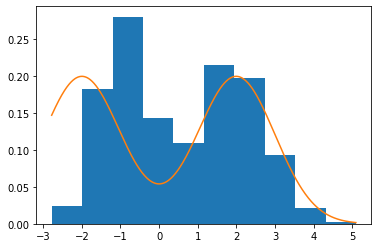

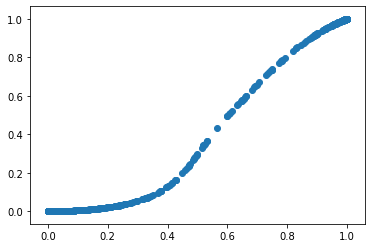

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  62: TIME: 4.44 ETA: 168.57 AE_LOSS: 0.1631 DC_LOSS: 1.3842 DC_ACC: 0.5074 GEN_LOSS: 0.6934
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


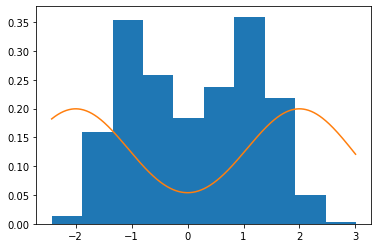

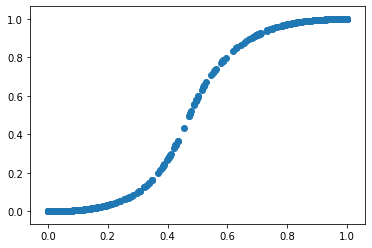

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  63: TIME: 4.43 ETA: 163.85 AE_LOSS: 0.1556 DC_LOSS: 1.3851 DC_ACC: 0.5074 GEN_LOSS: 0.7117
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


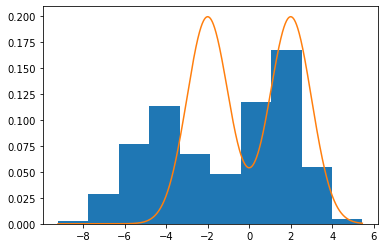

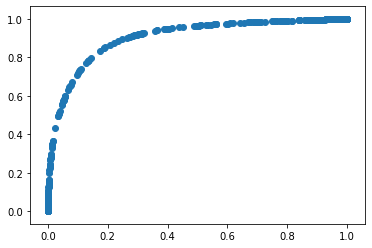

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  64: TIME: 4.47 ETA: 161.08 AE_LOSS: 0.1696 DC_LOSS: 1.3868 DC_ACC: 0.5074 GEN_LOSS: 0.6926
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


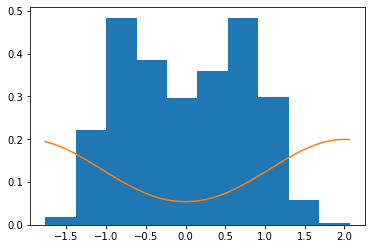

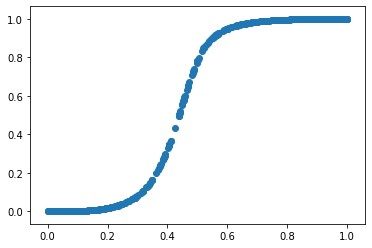

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  65: TIME: 4.53 ETA: 158.63 AE_LOSS: 0.1391 DC_LOSS: 1.3873 DC_ACC: 0.5073 GEN_LOSS: 0.6956
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


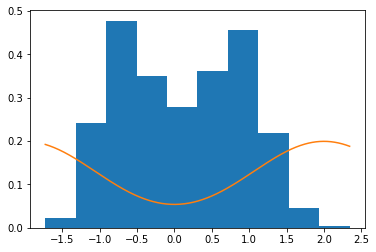

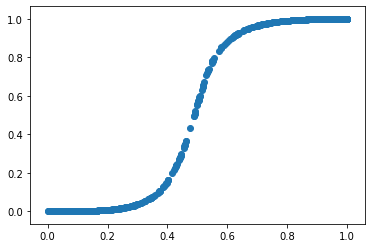

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  66: TIME: 4.34 ETA: 147.46 AE_LOSS: 0.1443 DC_LOSS: 1.3822 DC_ACC: 0.5072 GEN_LOSS: 0.7022
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


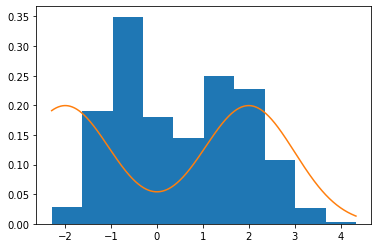

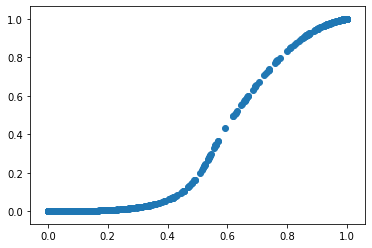

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  67: TIME: 4.56 ETA: 150.46 AE_LOSS: 0.1672 DC_LOSS: 1.3876 DC_ACC: 0.5072 GEN_LOSS: 0.6949
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


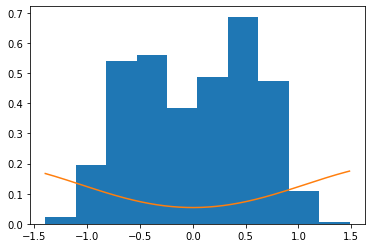

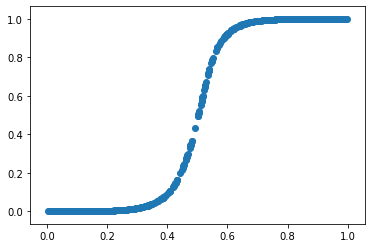

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  68: TIME: 4.39 ETA: 140.40 AE_LOSS: 0.1386 DC_LOSS: 1.3754 DC_ACC: 0.5072 GEN_LOSS: 0.7048
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


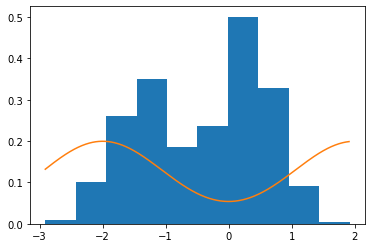

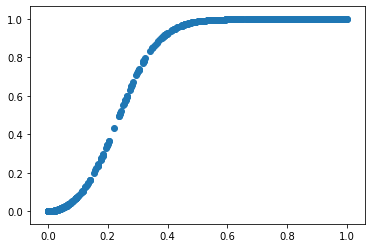

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  69: TIME: 4.48 ETA: 139.03 AE_LOSS: 0.2060 DC_LOSS: 1.3796 DC_ACC: 0.5075 GEN_LOSS: 0.7163
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


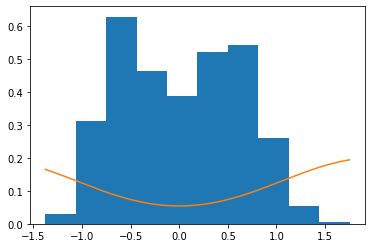

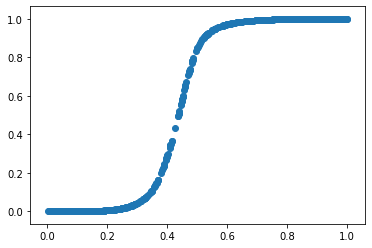

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  70: TIME: 4.51 ETA: 135.26 AE_LOSS: 0.2495 DC_LOSS: 1.3881 DC_ACC: 0.5080 GEN_LOSS: 0.7327
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


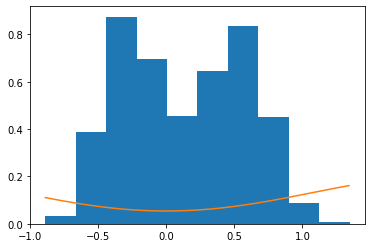

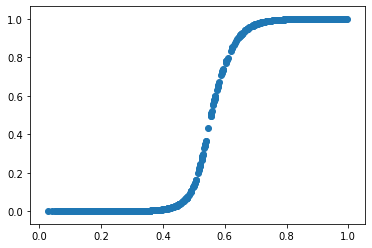

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  71: TIME: 4.42 ETA: 128.32 AE_LOSS: 0.1501 DC_LOSS: 1.3626 DC_ACC: 0.5081 GEN_LOSS: 0.7047
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


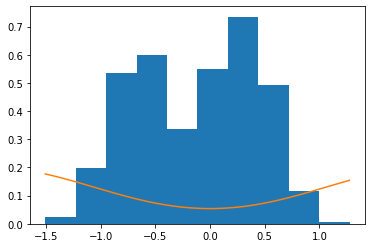

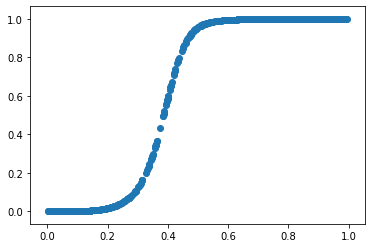

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  72: TIME: 4.32 ETA: 120.99 AE_LOSS: 0.2549 DC_LOSS: 1.3424 DC_ACC: 0.5091 GEN_LOSS: 0.7620
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


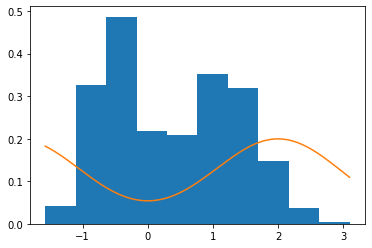

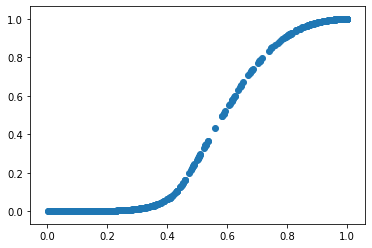

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  73: TIME: 4.52 ETA: 122.16 AE_LOSS: 0.2744 DC_LOSS: 1.3527 DC_ACC: 0.5103 GEN_LOSS: 0.7367
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


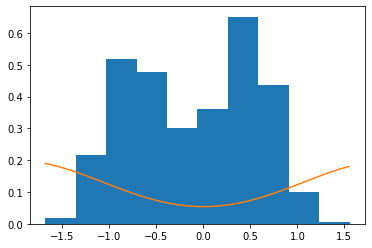

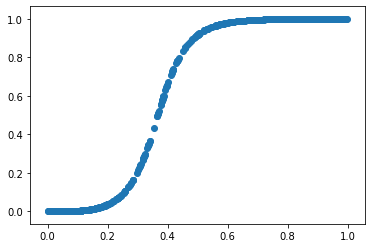

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  74: TIME: 4.54 ETA: 118.14 AE_LOSS: 0.2086 DC_LOSS: 1.3811 DC_ACC: 0.5112 GEN_LOSS: 0.7372
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


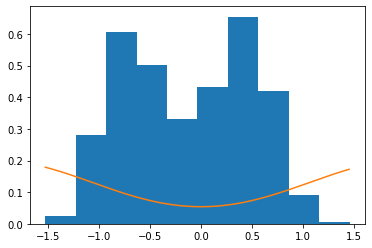

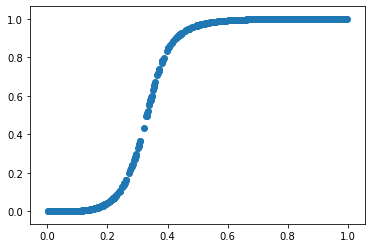

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  75: TIME: 4.47 ETA: 111.81 AE_LOSS: 0.1921 DC_LOSS: 1.3719 DC_ACC: 0.5115 GEN_LOSS: 0.7276
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


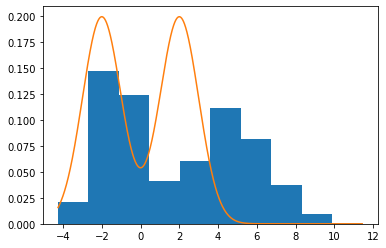

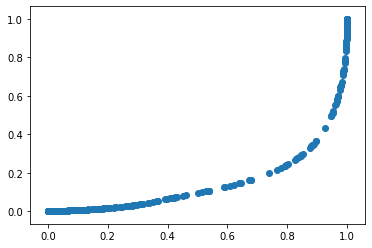

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  76: TIME: 4.50 ETA: 107.95 AE_LOSS: 0.2009 DC_LOSS: 1.3854 DC_ACC: 0.5117 GEN_LOSS: 0.7005
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


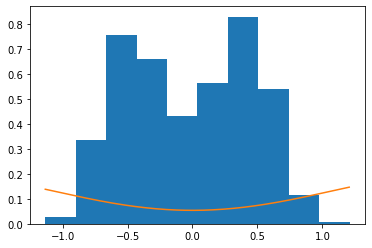

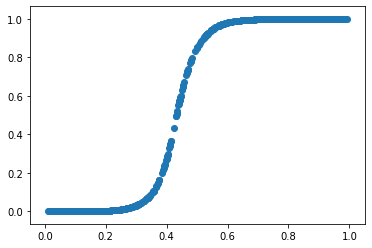

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  77: TIME: 4.48 ETA: 103.02 AE_LOSS: 0.1585 DC_LOSS: 1.3518 DC_ACC: 0.5118 GEN_LOSS: 0.7446
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


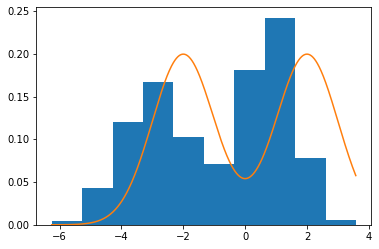

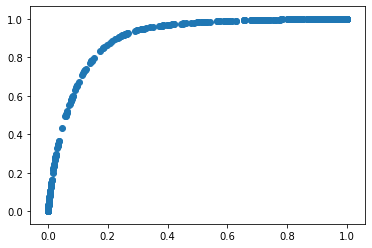

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  78: TIME: 4.31 ETA: 94.91 AE_LOSS: 0.1786 DC_LOSS: 1.3947 DC_ACC: 0.5122 GEN_LOSS: 0.7121
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


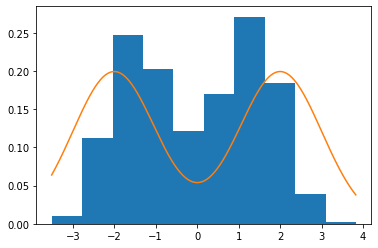

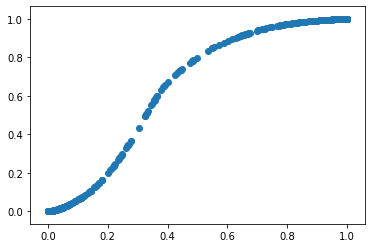

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  79: TIME: 4.54 ETA: 95.38 AE_LOSS: 0.1478 DC_LOSS: 1.3819 DC_ACC: 0.5120 GEN_LOSS: 0.6996
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


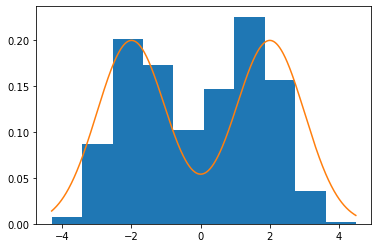

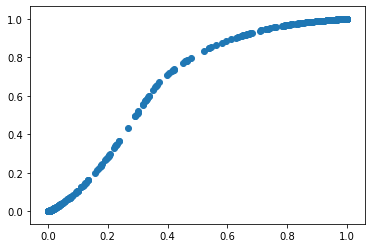

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  80: TIME: 4.43 ETA: 88.51 AE_LOSS: 0.1719 DC_LOSS: 1.3973 DC_ACC: 0.5119 GEN_LOSS: 0.6888
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


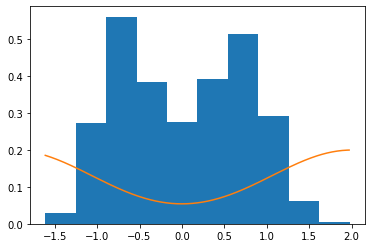

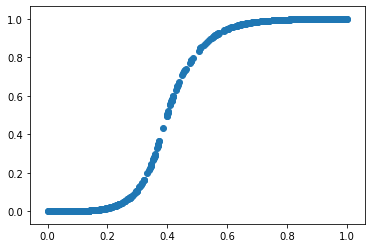

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  81: TIME: 4.34 ETA: 82.38 AE_LOSS: 0.1480 DC_LOSS: 1.3740 DC_ACC: 0.5117 GEN_LOSS: 0.7061
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


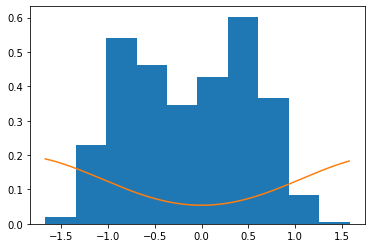

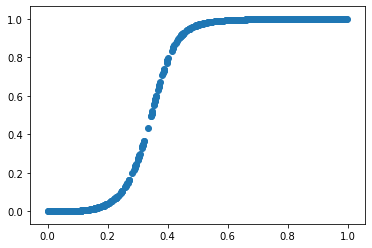

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  82: TIME: 4.51 ETA: 81.21 AE_LOSS: 0.1714 DC_LOSS: 1.3749 DC_ACC: 0.5120 GEN_LOSS: 0.7261
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


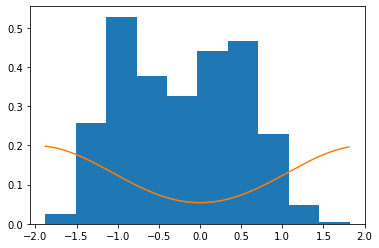

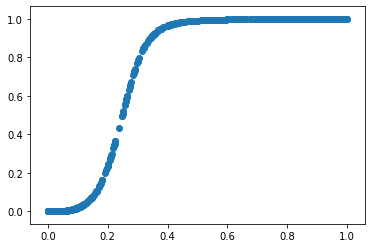

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  83: TIME: 4.41 ETA: 75.02 AE_LOSS: 0.1677 DC_LOSS: 1.3808 DC_ACC: 0.5124 GEN_LOSS: 0.7225
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


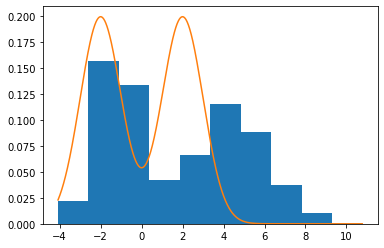

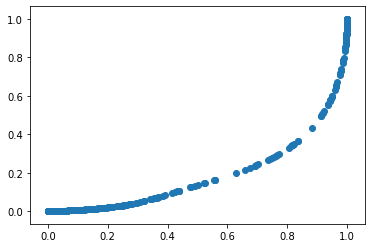

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  84: TIME: 4.61 ETA: 73.73 AE_LOSS: 0.1841 DC_LOSS: 1.3648 DC_ACC: 0.5126 GEN_LOSS: 0.7209
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


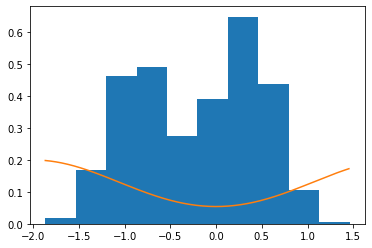

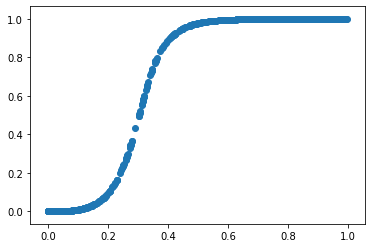

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  85: TIME: 4.55 ETA: 68.20 AE_LOSS: 0.1905 DC_LOSS: 1.3683 DC_ACC: 0.5131 GEN_LOSS: 0.7490
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


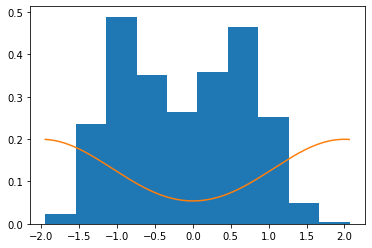

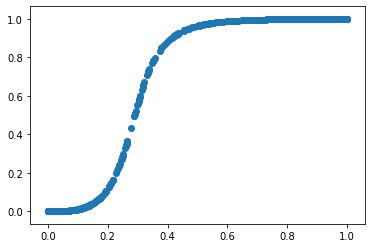

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  86: TIME: 4.40 ETA: 61.62 AE_LOSS: 0.2270 DC_LOSS: 1.3836 DC_ACC: 0.5136 GEN_LOSS: 0.7117
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


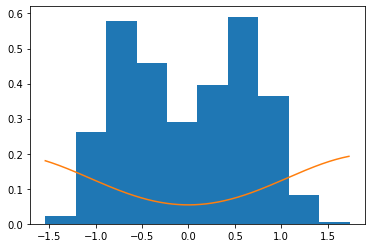

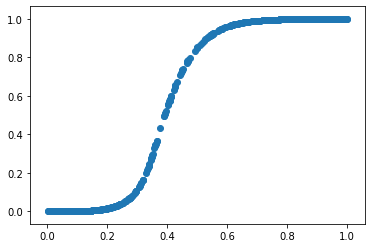

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  87: TIME: 4.52 ETA: 58.79 AE_LOSS: 0.1593 DC_LOSS: 1.3874 DC_ACC: 0.5135 GEN_LOSS: 0.6981
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


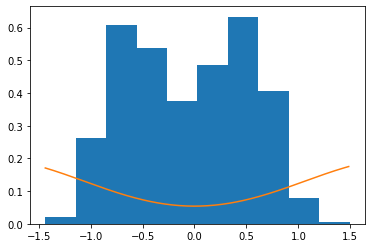

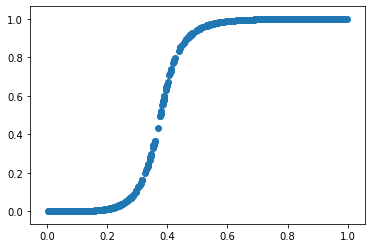

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  88: TIME: 4.62 ETA: 55.39 AE_LOSS: 0.1400 DC_LOSS: 1.3790 DC_ACC: 0.5134 GEN_LOSS: 0.6981
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


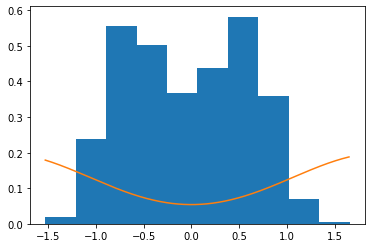

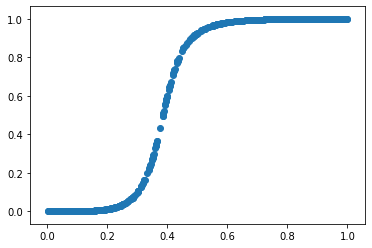

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  89: TIME: 4.46 ETA: 49.04 AE_LOSS: 0.1564 DC_LOSS: 1.3661 DC_ACC: 0.5137 GEN_LOSS: 0.7181
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


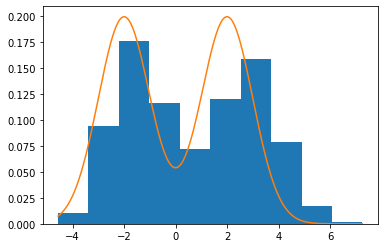

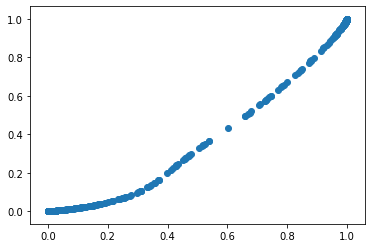

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  90: TIME: 4.60 ETA: 46.02 AE_LOSS: 0.1548 DC_LOSS: 1.3846 DC_ACC: 0.5137 GEN_LOSS: 0.7046
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


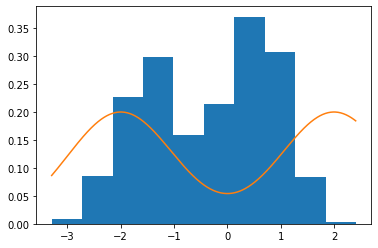

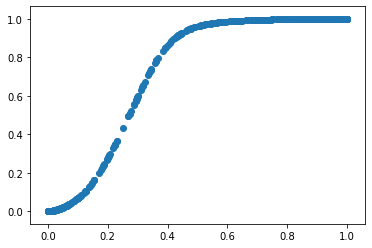

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  91: TIME: 4.49 ETA: 40.41 AE_LOSS: 0.1699 DC_LOSS: 1.3810 DC_ACC: 0.5136 GEN_LOSS: 0.7117
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


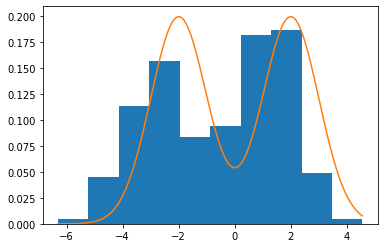

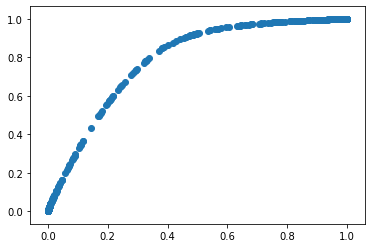

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  92: TIME: 4.49 ETA: 35.90 AE_LOSS: 0.1600 DC_LOSS: 1.3898 DC_ACC: 0.5135 GEN_LOSS: 0.6929
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


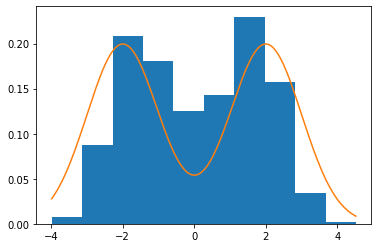

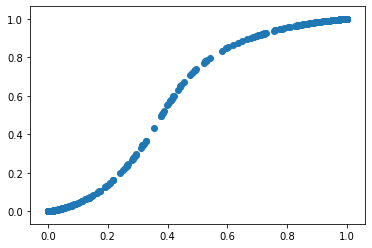

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  93: TIME: 4.43 ETA: 31.01 AE_LOSS: 0.1390 DC_LOSS: 1.3899 DC_ACC: 0.5134 GEN_LOSS: 0.6975
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


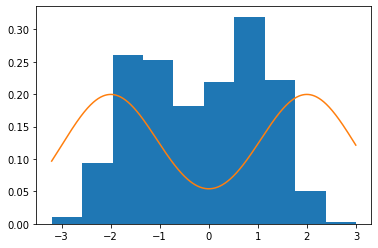

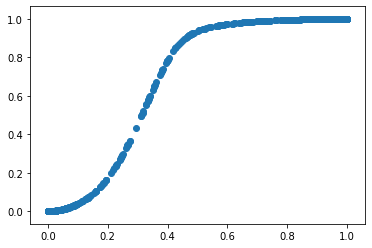

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  94: TIME: 4.41 ETA: 26.47 AE_LOSS: 0.1397 DC_LOSS: 1.3840 DC_ACC: 0.5132 GEN_LOSS: 0.6996
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


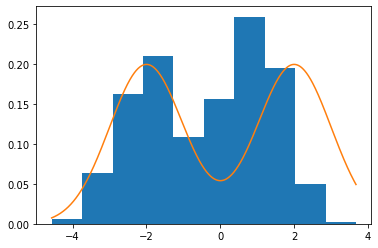

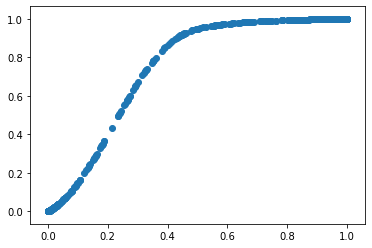

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  95: TIME: 4.56 ETA: 22.80 AE_LOSS: 0.1435 DC_LOSS: 1.3852 DC_ACC: 0.5131 GEN_LOSS: 0.6994
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


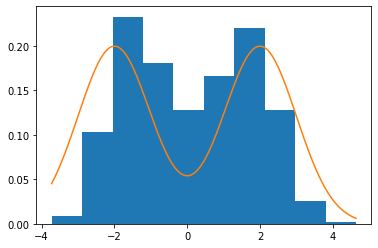

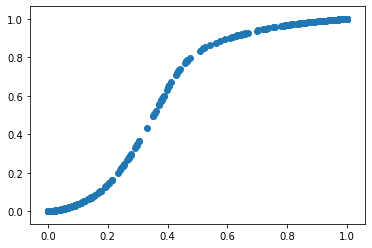

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  96: TIME: 4.54 ETA: 18.16 AE_LOSS: 0.1439 DC_LOSS: 1.3878 DC_ACC: 0.5130 GEN_LOSS: 0.6915
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


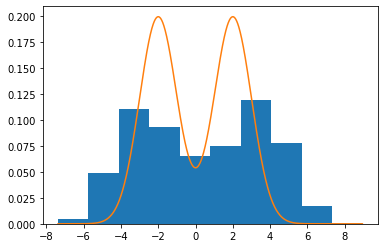

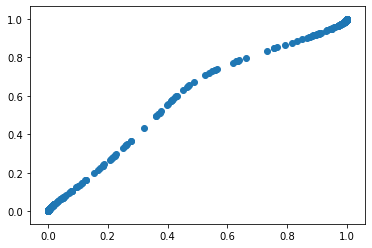

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  97: TIME: 4.47 ETA: 13.40 AE_LOSS: 0.1415 DC_LOSS: 1.3884 DC_ACC: 0.5128 GEN_LOSS: 0.6970
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


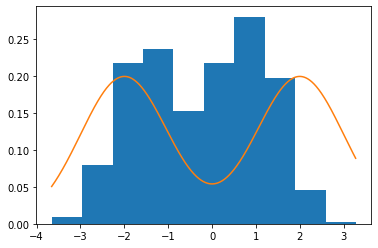

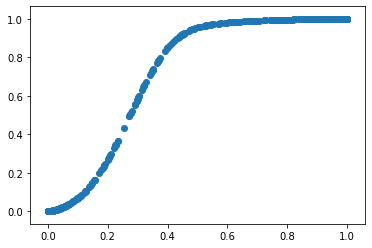

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  98: TIME: 4.46 ETA: 8.91 AE_LOSS: 0.1286 DC_LOSS: 1.3863 DC_ACC: 0.5127 GEN_LOSS: 0.6979
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


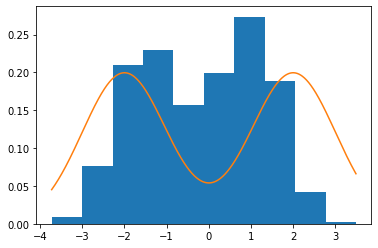

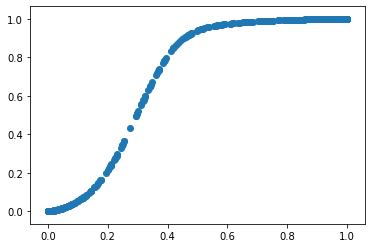

<tf.Variable 'count:0' shape=() dtype=float32, numpy=78.0> 78
  99: TIME: 4.45 ETA: 4.45 AE_LOSS: 0.1294 DC_LOSS: 1.3849 DC_ACC: 0.5126 GEN_LOSS: 0.6966
[[-2]
 [ 2]] [[[1]]

 [[1]]]


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


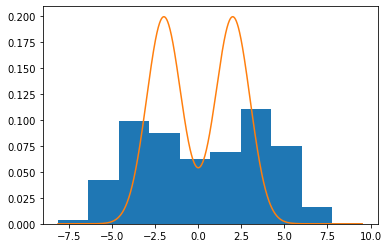

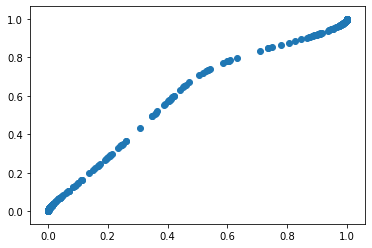

In [205]:
aae.fit(xUnlabeledTrain,
        xPosTrain,
        validation_data=(xUnlabeledVal,xPosVal),
        n_epochs=100,
        batch_size=128,
       params=EasyDict({
           "u0" : np.array([-2]),
           "sigma0" : np.array([[1]]),
           "u1" : np.array([2]),
           "sigma1" : np.array([[1]]),
           "alpha" : classPrior
       }))